# ==========
# = Iteration #5 =
# ==========

## Stage 1: Planning
The tasks for this stage are:
1. Compose the project team
2. Set the research question
3. Schedule all review meeting to ensure iterations are time-boxed.

### 4.1.1. Compose the project team
The project team and Clinical Review Board are CMI and CB.

### 4.1.2. Set the research question
The research question is:

_What changes arise from increasing the set of medications being considered?_

The new requirements specified from the previous iteration are:

1. Change the intertest interval treshold for the R.A.M.E. status to a band between 2 and 7 months, to match [NICE's 3-6 months window](https://www.nice.org.uk/guidance/ng28/chapter/Recommendations) plus some wiggle room.
2. Change R.A.M.E. to H.M.A. (Hold-Monitor-Adjust) by merging the categories for Adjust and Monitor, and replacing 'Run' with 'Hold'. This gives an ordinal variable.
3. Remove the limit to only three medications (i.e. metformin, empagliflozin, gliclazide). Replace with medication defined by the first 9 digits of the BNF code (e.g. 'Insulin aspart 100units/ml inj 1.6ml cartridges' and 'Insulin NovoRapid' both become 'Insulin aspart'.

### 4.1.3. Schedule all review meeting to ensure iterations are time-boxed
CMI and CB will meet in their regular Thursday-morning meeting, which will now be fortnightly.

## Stage 2: Extraction
This tasks for this stage are:
1. Gather knowledge and insight into the processes under study and the data-generating mechanisms.
2. Obtain data for processing

### 4.2.1. Gather knowledge and insight into the processes under study and the data-generating mechanisms.
Regarding the processes under study, I, the modeller, discuss the project during weekly meetings with an experienced GP who is a professor of primary medical care.
Regarding data-generating mechanisms, I, the modeller, have gathered knowledge from over half a decade experience collaborating with clinicians and patients on research projects about electronic healthcare 
records. 

### 4.2.2. Obtain data for processing
Data have been obtain by agreement via Connected Bradford. Data are queryable via this Jupyter notebook on the GoogleCloudPlatform using AI Vertex Workbench.

Select which portions of the notebook to run.

In [64]:
# Select which portions of the notebook to run.
# ## Some of these are dependent on others so you might get
# ## warning messages if requisite data aren't available
# ## because a portion of the notebook was skipped.
run_all <- TRUE # {TRUE, FALSE, NA}
run_install <- ifelse( is.na( run_all ), TRUE, run_all )
run_define_cohort <- ifelse( is.na( run_all ), TRUE, run_all )
run_add_stratification_variables <- ifelse( is.na( run_all ), TRUE, run_all )
run_create_sts_objects <- ifelse( is.na( run_all ), TRUE, run_all )
run_process_mining_summary <- ifelse( is.na( run_all ), FALSE, run_all )
run_complexity_statistics <- ifelse( is.na( run_all ), FALSE, run_all )
run_Sankey_plots <- ifelse( is.na( run_all ), TRUE, run_all )
run_laneSwitching_plots <- ifelse( is.na( run_all ), TRUE, run_all )
run_evaluation_rig <- ifelse( is.na( run_all ), FALSE, run_all )

Install R packages.

In [65]:
#######################
## Install packages. ##
#######################
if ( run_install )
    {
        #devtools::install_github("davidsjoberg/ggsankey")
        install.packages( "pacman" )
        library( pacman )
        pacman::p_load(
            bigrquery
            ,data.table
            ,GGally
            ,ggsankey
            ,gtable
            ,grid
            ,gridExtra
            ,paletteer
            ,readr
            ,tidytext
            ,tidyverse
            ,TraMineR
            ,TraMineRextras
            
        )
    }


#remotes::install_version("<name>", "<version>")
#install.packages("<name>", dependencies = TRUE, repos='http://cran.rstudio.com/')

#remotes::install_version("dbplyr", "2.3.4")
#library(dbplyr)
#available.packages()['dbplyr',]

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



Set and load requisites.

In [250]:
##############################
## Set and load requisites. ##
##############################

# Setup connection to GCP.
project_id = "yhcr-prd-phm-bia-core"
con <- DBI::dbConnect( drv = bigquery(), project = project_id ) %>% suppressWarnings()

# Define R tibbles from GCP tables.
#r_tbl_srcode <- dplyr::tbl( con, dbplyr::in_schema( sql( "CB_FDM_PrimaryCare" ), sql( "tbl_srcode" ) ) )
r_tbl_srcode <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srcode" )
r_tbl_srpatient <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srpatient" )
r_tbl_BNF_DMD_SNOMED_lkp <- dplyr::tbl( con, "CB_LOOKUPS.tbl_BNF_DMD_SNOMED_lkp" )
r_tbl_srprimarycaremedication <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srprimarycaremedication" )
r_tbl_srappointment <- dplyr::tbl( con, "CB_FDM_PrimaryCare.tbl_srappointment" )

# Clinical code lists (BNF, SNOMED-CT, etc).
# ## Medication codes.
codes_SNOMED_diagnoses_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-dmtype2_cod-20200812.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_test_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-glycated-haemoglobin-hba1c-tests-3e5b1269.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_BNF_metformin <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-metformin-bnf-0601022b0-and-child-bnf-codes-only-43e7d87e.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
names_metformin_meds <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_metformin ) %>%
    dplyr::select( DMplusD_ProductDescription )
BNF_meds_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-bnf-section-61-drugs-for-diabetes-207573b7.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )
codes_BNF_meds_of_interest <-
    BNF_meds_of_interest$code
# ## ## Aggregate the medications to the first nine digits of their BNF codes.
names_meds_of_interest <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_meds_of_interest ) %>%
    dplyr::select( BNF_Code, DMplusD_ProductDescription ) %>%
    dplyr::mutate(
        BNF_Code_short = stringr::str_sub( BNF_Code, end = 9 )
        ) 
shortNames_meds_of_interest <-
    names_meds_of_interest %>%
    dplyr::collect() %>%
    dplyr::left_join(
         BNF_meds_of_interest %>% filter(nchar(code) == 9)
        ,by = join_by( BNF_Code_short == code )
    ) %>%
    dplyr::select( -c( BNF_Code, BNF_Code_short ) ) %>%
    dplyr::rename(
        drug_name = DMplusD_ProductDescription
        ,drug_name_short = term
    ) %>%
    dplyr::distinct()
# ## Multimorbidity codes.
codes_SNOMED_depression <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-depr_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_anxiety <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-anxiety-disorders-6aef605a.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_substanceAbuse <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-illsub_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_dementia <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-dem_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_SMI <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-mh_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_arthritis <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-c19rarth_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_lungCancer <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-lung-cancer-snomed-2020-04-15.csv' ),
                    col_types = cols( id = col_character(), name = col_character() ) )$id
codes_SNOMED_otherCancer <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-cancer-excluding-lung-and-haematological-snomed-2020-04-15.csv' ),
                    col_types = cols( id = col_character(), name = col_character() ) )$id
codes_SNOMED_haemCancer <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-c19haemcan_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_hypertension <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-hyp_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_hyperlipid <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-hyperlipidaemia-68d4d269.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_cardiacArrhythmia <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-cardiac-arrhythmias-4fc55f34.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_asthma <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-ast_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_CAD <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-coronary-artery-disease-36b5ebff.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_COPD <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-copd_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_osteo <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-osteo_cod-20200812.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_CKD1and2 <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-ckd1and2atrisk1_cod-20200812.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_CKD3to5 <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-ckdatrisk2_cod-20210127.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_CHF <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-congestive-heart-failure-1da678ca.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_hepatitis <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-hepatitis-04970595.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_all_multimorbidity_diagnoses <-
    c(
        codes_SNOMED_anxiety
        ,codes_SNOMED_arthritis
        ,codes_SNOMED_asthma
        ,codes_SNOMED_CAD
        ,codes_SNOMED_cardiacArrhythmia
        ,codes_SNOMED_CHF
        ,codes_SNOMED_CKD1and2
        ,codes_SNOMED_CKD3to5
        ,codes_SNOMED_COPD
        ,codes_SNOMED_depression
        ,codes_SNOMED_dementia
        ,codes_SNOMED_haemCancer
        ,codes_SNOMED_hepatitis
        ,codes_SNOMED_hyperlipid
        ,codes_SNOMED_hypertension
        ,codes_SNOMED_lungCancer
        ,codes_SNOMED_osteo
        ,codes_SNOMED_otherCancer
        ,codes_SNOMED_SMI
        ,codes_SNOMED_substanceAbuse
    )
# ## Did-not-attend.
codes_SNOMED_didNotAttend <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-did-not-attend-098119da.csv' ),
                    col_types = cols( code = col_character(), term = col_character() ) )$code

# Load the CSV file containing that matches all medications in `codes_SNOMED_diagnoses_of_interest`
# with an expected duration of prescription.
##meds_expected_prescription_duration <-
 ##   readr::read_csv(file = 'meds_expected_prescription_duration.csv',
  ##                  col_types = cols( term = col_character(), duration = col_numeric() ) )

# Study start date
date_study_start <- lubridate::ymd('2018-06-01')
date_study_end <- lubridate::ymd('2020-12-31')

# Duration of months after the first prescription that we ignore before studying patterns.
pattern_delay_months <- 0

# Threshold value for the test, which in this case is HbA1c.
val_test_threshold <- 48

# Threshold for the expected interval between subsequent tests, in months
val_testing_interval_LB <- 2
val_testing_interval_UB <- 7

# Set values for meaningful changes in the values of the test.
val_meaningful_test_improvement <- -10
val_meaningful_test_disimprovement <- 10

# Set window within which to search for repeated (but not repeat) prescriptions.
window_repeated_prescription_months <- 3

# Set number of tests, treatments, or iterations after diagnosis that should be tracked.
n_iterations <- 20

# Set the window within which mutimorbidity diagnoses and the index must fit in, in months.
multimorb_inclusion_window_months <- 60

# Set the window outwith which at least two mutimorbidity diagnoses must be of each other, in months.
multimorb_gap_window_months <- 1

# Set ordering of factors labels for the event variable.
df_event_factor <-
    data.frame(
        event_fct_order =
            factor(
                c( "Test Status = Red", "Test Status = Amber"
                  ,"Test Status = Yellow", "Test Status = Green"
                  ,shortNames_meds_of_interest %>%
                  dplyr::distinct( drug_name_short ) %>%
                  dplyr::arrange( drug_name_short ) %>%
                  dplyr::pull( drug_name_short )
                  ,"Unobserved"
                 )
                ,levels = c( "Test Status = Red", "Test Status = Amber"
                            ,"Test Status = Yellow", "Test Status = Green"
                            ,shortNames_meds_of_interest %>%
                            dplyr::distinct( drug_name_short ) %>%
                            dplyr::arrange( drug_name_short ) %>%
                            dplyr::pull( drug_name_short )
                            ,"Unobserved" 
                           )
            )
        ,event_colours_order = c( "firebrick1", "darkorange", "gold", "limegreen"
                                 ,paletteer_c("grDevices::Plasma"
                                              ,shortNames_meds_of_interest %>%
                                              dplyr::distinct( drug_name_short ) %>%
                                              nrow()
                                             )
                                 ,"grey"
                                 )
    )

# Set ordering of H.M.A. stratification.
df_HMA_factor <-
    data.frame(
        HMA_fct_order =
            factor(
                c("Hold", "Monitor", "Adjust", "Unobserved")
                ,levels = c("Hold", "Monitor","Adjust", "Unobserved")
            )
        ,HMA_colours_order = c( "plum1", "lightcoral", "cornflowerblue", "grey" )
    )


# Set ordering of HMAandTestStatus stratification.
df_HMAandTestStatus_factor <-
    data.frame(
        HMAandTestStatus_fct_order =
            factor(
                c(
                  "Hold Red" ,"Hold Amber" ,"Hold Yellow" ,"Hold Green"
                  ,"Monitor Red","Monitor Amber", "Monitor Yellow", "Monitor Green"
                  ,"Adjust Red", "Adjust Amber", "Adjust Yellow", "Adjust Green"
                  ,"Unobserved"
                 )
                ,levels = 
                    c(
                      "Hold Red" ,"Hold Amber" ,"Hold Yellow" ,"Hold Green"
                      ,"Monitor Red","Monitor Amber", "Monitor Yellow", "Monitor Green"
                      ,"Adjust Red", "Adjust Amber", "Adjust Yellow", "Adjust Green"
                      ,"Unobserved"
                     )
            )
        ,HMAandTestStatus_colours_order =
                c( rep( c("firebrick1", "darkorange", "gold", "limegreen"), times = 3), "grey" )
    )

# Set ordering of TandI stratification.
df_TandI_factor <-
    data.frame(
        TandI_fct_order =
            factor(
                c(
                    'Red Zero Rx', 'Red One Rx', 'Red Two Rx', 'Red More Rx',
                    'Amber Zero Rx', 'Amber One Rx', 'Amber Two Rx', 'Amber More Rx',
                    'Yellow Zero Rx', 'Yellow One Rx', 'Yellow Two Rx', 'Yellow More Rx',
                    'Green Zero Rx', 'Green One Rx', 'Green Two Rx', 'Green More Rx',
                    'Unobserved'
                )
                ,levels =
                c(
                    'Red Zero Rx', 'Red One Rx', 'Red Two Rx', 'Red More Rx',
                    'Amber Zero Rx', 'Amber One Rx', 'Amber Two Rx', 'Amber More Rx',
                    'Yellow Zero Rx', 'Yellow One Rx', 'Yellow Two Rx', 'Yellow More Rx',
                    'Green Zero Rx', 'Green One Rx', 'Green Two Rx', 'Green More Rx',
                    'Unobserved'
                )
            )
        ,TandI_colours_order =
                c(
                    "red" # 1: Test status == Red & Zero prescriptions
                    ,"firebrick3" # 2: Test status == Red & One prescriptions
                    ,"firebrick4" # 3: Test status == Red & Two prescriptions
                    ,"darkred" # 4: Test status == Red & Three prescriptions

                    ,"orange" # 5: Test status == Amber & Zero prescriptions
                    ,"darkorange2" # 6: Test status == Amber & One prescriptions
                    ,"darkorange3" # 7: Test status == Amber & Two prescriptions
                    ,"darkorange4" # 8: Test status == Amber & Three prescriptions

                    ,"yellow" # 9: Test status == Yellow & Zero prescriptions
                    ,"gold2" # 10: Test status == Yellow & One prescriptions
                    ,"gold3" # 11: Test status == Yellow & Two prescriptions
                    ,"gold4" # 12: Test status == Yellow & Three prescriptions

                    ,"green" # 13: Test status == Green & Zero prescriptions
                    ,"chartreuse2" # 14: Test status == Green & One prescriptions
                    ,"chartreuse3" # 15: Test status == Green & Two prescriptions
                    ,"chartreuse4" # 16: Test status == Green & Three prescriptions

                    ,"grey" # 0 = Unobserved
                )
    )

# Set ordering of TandMultiMorb stratification.
df_TandMultiMorb_factor <-
    data.frame(
        TandMultiMorb_fct_order =
            factor(
                c(
                    'Red Multimorbid', 'Amber Multimorbid', 'Yellow Multimorbid', 'Green Multimorbid',
                    'Red Not multimorbid', 'Amber Not multimorbid', 'Yellow Not multimorbid', 'Green Not multimorbid',
                    'Unobserved'
                )
                ,levels =
                c(
                    'Red Multimorbid', 'Amber Multimorbid', 'Yellow Multimorbid', 'Green Multimorbid',
                    'Red Not multimorbid', 'Amber Not multimorbid', 'Yellow Not multimorbid', 'Green Not multimorbid',
                    'Unobserved'
                )
            )
        ,TandMultiMorb_colours_order =
                c(
                    "red4" # 1: Test status == Red & Multimorbid
                    ,"orangered3" # 2: Test status == Amber & Multimorbid
                    ,"gold2" # 3: Test status == Yellow & Multimorbid
                    ,"darkgreen" # 4: Test status == Green & Multimorbid
                    
                    ,"red" # 5: Test status == Red & Not multimorbid
                    ,"orange" # 6: Test status == Amber & Not multimorbid
                    ,"yellow" # 7: Test status == Yellow & Not multimorbid
                    ,"green" # 8: Test status == Green & Not multimorbid

                    ,"grey" # 0 = Unobserved
                )
    )

Define study cohort.

In [251]:
####################
## Define cohort. ##
####################
# The cohort is defined as records that include a diagnosis for Type 2 Diabetes Mellitus (T2DM)
# and a prescription for metformin as the only diabetic medication for the first prescription.
# The following queries create this list of records that are within the Connected Bradford primary
# care table.
#
# Select records from primary care that have a clinical code for a T2DM diagnosis. Include a column
# showing the earliest date of diagnosis. Filter for within the study period.
#
if ( run_define_cohort )
    {
        ppl_with_T2DM_diagnoses <-
            r_tbl_srcode %>%
            dplyr::filter( snomedcode %in% codes_SNOMED_diagnoses_of_interest ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::summarise( date_diagnosis = min( dateevent, na.rm = TRUE ) ) %>%
            dplyr::select( person_id, date_diagnosis ) %>%
            dplyr::filter( dplyr::between(date_diagnosis, date_study_start, date_study_end) ) %>%
            dplyr::ungroup()
    }

Retrieve dates of prescriptions that followed diagnosis.

In [252]:
if ( run_define_cohort )
    {
        qry_log_prescription <-
        ########################################################################################################
        ## Select list of person IDs that have a metformin prescription as their first diabetic prescription. ## 
        ########################################################################################################
            # Select from the medication table the records for those patients who have a diagnosis.
            ppl_with_T2DM_diagnoses %>%
            dplyr::left_join( r_tbl_srprimarycaremedication, by = join_by( person_id ) ) %>%
            # Select every record that has a prescription for any diabetes medication.
            dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
            # Filter for records after the date of diagnosis.
            dplyr::filter( dateevent >= date_diagnosis ) %>%
            # Extract the first prescription.
            dplyr::group_by( person_id ) %>%
            dplyr::summarise( date_first_prescription = min( dateevent, na.rm = TRUE ) ) %>%
            dplyr::ungroup() %>%
            # Re-join to the original table to get the name of the medication.
            dplyr::left_join( r_tbl_srprimarycaremedication, by = join_by( person_id, date_first_prescription == dateevent ) ) %>%
            dplyr::select( person_id, date_first_prescription, nameofmedication, isrepeatmedication, medicationquantity, medicationdosage ) %>%
            dplyr::distinct() %>%
            # Use an inner join to filter these first prescriptions for the metformin medications, only.
            dplyr::inner_join( names_metformin_meds, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
            dplyr::distinct() %>%
            # Select the required fields.
            dplyr::select( person_id, date_first_prescription )

        ##############################################################
        ## Retrieve dates of prescriptions that followed diagnosis. ##
        ##############################################################
        # Note: If more than one medication was prescribed on the same day, then they are considered
        #       to be the i-th and i+1-th prescription, ordered alphabetically. This will manifest
        #       as two of the `date_next_prescription_*` fields having the same date, and one of the
        #       `interval_prescp_to_prescp_*` fields correctly showing 0 days between the prescriptions.
        #
        qry_log_prescription_longFormat <-
            qry_log_prescription %>%
            # Join to medications table.
            dplyr::inner_join( r_tbl_srprimarycaremedication, by = join_by( person_id ) ) %>%
            # Select every record that has a prescription for any diabetes medication.
            dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>% 
            # Filter for records after the date of diagnosis.
            dplyr::left_join( ppl_with_T2DM_diagnoses, by = join_by( person_id ) ) %>%
            dplyr::filter( dateevent >= date_diagnosis ) %>%
            # Extract the required fields.
            dplyr::select( person_id, dateevent, nameofmedication, date_first_prescription ) %>%
            # Filter for tests that were done after the pattern start date.
            dplyr::group_by( person_id ) %>%
            dplyr::filter(
                dateevent > sql(paste0( 'DATETIME_ADD( date_first_prescription, INTERVAL ', pattern_delay_months, ' MONTH )') )
            ) %>% 
            # Remove `date_first_prescription` because it is no longer needed.
            dplyr::select( - date_first_prescription ) %>%
            dplyr::distinct() %>%
            # Filter for however many subsequent prescriptions were specified in `n_iteraions`, then number them.
            dbplyr::window_order( person_id, dateevent, nameofmedication ) %>% 
            dplyr::filter( row_number() <= n_iterations + 1 ) %>% # The "+ 1" is added so that we always include the final "Unobserved" state.
            dplyr::mutate( event_name = paste0( "prescription_", row_number() ) ) %>% 
            # Rename columns.
            dplyr::rename(
                start_dttm = dateevent
                ,event_value = nameofmedication
            ) %>%
            # Set the end time each prescription as the start time of the previous one.
            dplyr::group_by( person_id ) %>%
            dbplyr::window_order( person_id, start_dttm ) %>%
            dplyr::mutate(
                end_dttm = dplyr::if_else( event_name == "diagnosis", start_dttm, lead( start_dttm ) )
            ) %>%
            dplyr::mutate_at(
                .vars = vars( end_dttm )
                ,.funs = funs( dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm ) )
            ) %>%
            dplyr::ungroup() %>%
            suppressWarnings()

        df_log_prescription_wideFormat <-
            qry_log_prescription_longFormat %>%
            dplyr::mutate_at( .vars = vars( event_name ), .funs = funs( gsub("prescription_", "prescp", . ) ) ) %>%
            tidyr::pivot_wider(
                names_from = event_name
                ,values_from = c( start_dttm, event_value )
                , names_sort = TRUE) %>%
            dplyr::ungroup() %>%
            suppressWarnings()
    }

Retrieve dates of tests that followed diagnosis.

In [253]:
# Retrieve the test result immediately before diagnosis.
if ( run_define_cohort )
    {
        test_value_before_diagnosis <-
            r_tbl_srcode %>%
            dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest) %>%
            dplyr::select( person_id, dateevent, numericvalue ) %>%
            dplyr::inner_join( ppl_with_T2DM_diagnoses, by = join_by( person_id ) ) %>%
            # Choose tests on or before the date of diagnosis.
            dplyr::filter( dateevent <= sql( paste0( 'DATETIME_ADD( date_diagnosis, INTERVAL 1 DAY )') ) ) %>%
            # Filter out test scores of 0, which are expected to be data entry anomalies, given my selection of columns.
            dplyr::filter( numericvalue != "0" ) %>%
            # Filter for the latest test before diagnosis.
            dplyr::group_by( person_id ) %>%
            dplyr::filter( dateevent == max( dateevent ) ) %>%
            # Filter for the largest score because, sometimes, a patient has two tests on the same latest date, one of which seems spuriously low.
            dplyr::filter( as.numeric(numericvalue) == max( as.numeric(numericvalue) ) ) %>%
            dplyr::ungroup() %>%
            # Tidy up the selection.
            dplyr::select( - date_diagnosis ) %>%
            dplyr::distinct()
    }

In [254]:
######################################################
## Retrieve dates of tests that followed diagnosis. ##
######################################################
if ( run_define_cohort )
    {
        qry_log_test_longFormat <- 
            r_tbl_srcode %>%
            # Filter records for only those that refer to the test of interest.
            dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest ) %>% 
            # Filter for only those patients that we already identified in our prescription table. Include the date of first prescripion.
            dplyr::inner_join( qry_log_prescription %>% dplyr::select( person_id, date_first_prescription )
                              ,by = join_by( person_id )
            ) %>%
            # Extract the required fields.
            dplyr::select( person_id, dateevent, numericvalue, date_first_prescription ) %>%
            # Filter out test scores of 0, which are expected to be data entry anomalies, given my selection of columns.
            dplyr::filter( numericvalue != "0" ) %>%
            # Filter for tests that were done after the pattern start date.
            dplyr::group_by( person_id ) %>%
            dplyr::filter(
                dateevent > sql(paste0( 'DATETIME_ADD( date_first_prescription, INTERVAL ', pattern_delay_months, ' MONTH )') )
            ) %>%
            dplyr::ungroup() %>%
            # Remove `date_first_prescription` because it is no longer needed.
            dplyr::select( - date_first_prescription ) %>% 
            # Rename columns.
            dplyr::rename(
                start_dttm = dateevent
                ,event_value_numeric = numericvalue
            ) %>% 
            # Include each person's date of diagnosis.
            dplyr::collect() %>%
            dplyr::group_by( person_id ) %>%
            dplyr::group_modify(~ tibble::add_row( .x, .before = 0 ), .by = person_id ) %>%
            dplyr::left_join( ppl_with_T2DM_diagnoses %>% collect(), by = join_by( person_id ) ) %>%
            dplyr::mutate(
                start_dttm = if_else( is.na( start_dttm ), date_diagnosis , start_dttm )
            ) %>%
            # Filter for records after the date of diagnosis.
            dplyr::filter( start_dttm >= date_diagnosis ) %>% 
            # Filter for however many subsequent tests were specified in `n_iteraions`, then number them.
            dplyr::distinct() %>%
            dplyr::group_by( person_id ) %>% 
            dplyr::arrange( start_dttm ) %>% 
            dplyr::filter( row_number() <= n_iterations + 1 ) %>% # The "+ 1" is added so that we always include the final "Unobserved" state.
            dplyr::mutate( event_name = paste0( "test_", row_number() - 1 ) ) %>% 
            dplyr::ungroup() %>% 
            # Include each person's date of test result just before diagnosis, and use this as the test result for the diagnosis.
            dplyr::left_join( test_value_before_diagnosis %>% collect(), by = join_by( person_id ) ) %>%
            dplyr::mutate(
                event_name = if_else( event_name == "test_0", "diagnosis", event_name )
                ,event_value_numeric = if_else( is.na( event_value_numeric ), numericvalue, event_value_numeric )
            ) %>% 
            dplyr::select( - c( date_diagnosis, numericvalue, dateevent ) ) %>%
            # Set the end time each test as the start time of the previous one.
            dplyr::group_by( person_id ) %>%
            dplyr::arrange( start_dttm ) %>%
            dplyr::mutate(
                end_dttm = lead( start_dttm )
            ) %>% 
            ## If the test is the final test, make the end time the start time.
            #dplyr::mutate_at(
            #    .vars = vars( end_dttm )
            #    ,.funs = funs( dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm ) )
            #) %>%
            dplyr::mutate_at( .vars = vars( event_value_numeric ), .funs = funs( as.numeric ) ) %>%
            # Convert the numeric test values into labels.
            dplyr::mutate(
                event_value = dplyr::case_when(
                    event_value_numeric > 70 ~ "Test Status = Red"
                    ,event_value_numeric > 58  ~ "Test Status = Amber"
                    ,event_value_numeric > 48 ~ "Test Status = Yellow"
                    ,TRUE ~ "Test Status = Green"
                    )
            ) %>%
            # Tidy up.
            dplyr::ungroup() %>%
            dplyr::select( - event_value_numeric ) %>%
            dplyr::distinct() %>%
            dplyr::arrange(person_id, start_dttm) %>%
            suppressWarnings() 

        ## Convert to wide format, if ever needed.
        #qry_log_test_wideFormat <-
        #    qry_log_test_longFormat %>%
        #    tidyr::pivot_wider(
        #        names_from = event_name
        #        ,values_from = c( start_dttm, event_value )
        #        ,names_sort = TRUE)
    }

Append the prescriptions and tests dataframe logs.

In [255]:
# Firstly, retrieve the dates of death, if they exist, and use them to inform a variable
# called `date_unobserved` to indicate the date from which we no longer observe
# the patient in the record.
if ( run_define_cohort )
    {
        df_date_unobserved <-
            r_tbl_srpatient %>%
            dplyr::select( person_id, datedeath ) %>% 
            dplyr::filter( !is.na( datedeath ) ) %>%
            dplyr::distinct() %>%
            dplyr::inner_join(
                ppl_with_T2DM_diagnoses
                ,by = join_by( person_id )
            ) %>%
            # Convert `datedeath` from a string of year and month, to a date object.
            dplyr::collect() %>%
            tidyr::separate(
                col = datedeath
                ,sep = 4
                ,into = c( "death_year", "death_month" )
            ) %>%
            dplyr::mutate(
                date_unobserved = ISOdate( year = death_year, month = death_month, day = 1, hour = 0 )
            ) %>%
            # Tidy up.
            dplyr::select( -c( death_year, death_month, date_diagnosis ) ) %>%
            dplyr::arrange( person_id )
    }

In [256]:
if ( run_define_cohort )
    {
        df_log_PandT_longFormat <-
            qry_log_prescription_longFormat %>%
            dplyr::collect() %>%
            dplyr::union_all( qry_log_test_longFormat ) %>%
            dplyr::ungroup() %>% 
            dplyr::distinct() %>%
            dplyr::arrange( person_id, start_dttm ) %>%
            # Include a date from which we stop observing the patient in the record.
            # This will be either the date of death or one second after the `end_dttm`
            # of the last event in a patient's record.
            dplyr::group_by( person_id ) %>%
            dplyr::group_modify( ~ tibble::add_row( .x ), .by = person_id ) %>% 
            dplyr::left_join( df_date_unobserved, by = join_by( person_id ) ) %>%
            dplyr::mutate(
                start_dttm = if_else( is.na( start_dttm ), date_unobserved , start_dttm )
            ) %>%
            dplyr::ungroup() %>%
            # Update `event_name` so that it shows "Unobserved", where appropriate.
            dplyr::mutate_at(
                .vars = vars( event_value )
                ,.funs = funs(
                    if_else( is.na( . ), "Unobserved", . )
                )
            ) %>%
            # Update `start_dttm` so that it shows one second after the last
            # `start_dttm` whenever `date_unobserved` is NA. 
            dplyr::mutate_at(
                .vars = vars( start_dttm )
                ,.funs = funs(
                    if_else( is.na( . ), lag( start_dttm ) + lubridate::seconds(1), . )
                )
            ) %>%
            # Update `end_dttm` for the final observed event. It should no longer read
            # as NA because the "Unobserved" follows it 
            dplyr::mutate_at(
                .vars = vars( end_dttm )
                ,.funs = funs(
                    if_else( lead( event_value ) == "Unobserved", lead( start_dttm ), . )
                )
            ) %>%
            suppressWarnings() %>%
            dplyr::select( - date_unobserved ) %>%
            dplyr::arrange( person_id, start_dttm ) #%>%
            ## Add the syntax that is below if you want the `end_dttm` variable that
            ## to be recalculated for the combined and ordered tests-and-prescrpitions.
            ## Otherwise, the `end_dttm` value for a given event is the `start_dttm` of
            ## the next test if the given event is a test, but is of the next prescription
            ## if the given event is a prescrition
            #dplyr::group_by( person_id ) %>%
            #dplyr::mutate_at(
            #    .vars = vars( end_dttm )
            #    ,.funs = funs(
            #        dplyr::if_else( event_name == "diagnosis", start_dttm, lead( start_dttm ) )
            #    )
            #) %>%
            #dplyr::mutate_at(
            #    .vars = vars( end_dttm )
            #    ,.funs = funs( dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm ) )
            #) %>%
            #dplyr::ungroup() %>%
            #suppressWarnings()

        #df_log_PandT_wideFormat <-
            #df_log_PandT_longFormat %>%
            #tidyr::pivot_wider(
            #    names_from = event_name
            #    ,values_from = c( start_dttm, event_value )
            #    ,names_sort = TRUE)
    }

Retrieve indication of diagnoses used in the calculation of comorbidity.

In this iteration, I will use the Mayo Clinic's definition* of two or more of 19 specified conditions, where diabetes is one, separated by 30 days ([Rocca et al. (2014)](http://dx.doi.org/10.1016/j.mayocp.2014.07.010)). This means that I only need to identify patients that have at least one of the diagnostic codes in `codes_SNOMED_all_multimorbidity_diagnoses` 30 days before or after their diagnosis for Type 2 Diabetes Mellitus.



\*Rocca et al. (2014) used ICD-10 codes but I use SNOMED-CT codes.

In [257]:
if ( run_define_cohort )
    {
        qry_log_multimorb_longFormat <-
            r_tbl_srcode %>%
            # Filter for only those patients that we already identified in our prescription table.
            dplyr::inner_join( qry_log_prescription %>% dplyr::select( person_id ), by = join_by( person_id ) ) %>%
            # Filter records for only those that refer to one of the diagnoses that constitute the multimorbidity variable.
            dplyr::filter( snomedcode %in% codes_SNOMED_all_multimorbidity_diagnoses ) %>% 
            # Extract the required fields.
            dplyr::select( person_id, dateevent, snomedcode ) %>%
            # Rename columns.
            dplyr::rename( date_multimorb = dateevent ) %>%
            # Include each person's date of diagnosis.
            dplyr::left_join( ppl_with_T2DM_diagnoses, by = join_by( person_id ) ) %>%
            # Filter for multimorbidity diagnoses recorded outwith the multimorbidity gap window of the date of diagnosis of the main diagnosis of interest.
            dplyr::filter(
                ( sql( paste0( 'DATE_DIFF( date_multimorb, date_diagnosis, MONTH)' ) ) %>% abs() ) >= multimorb_gap_window_months
            ) %>%
            dplyr::select( - c( date_diagnosis, snomedcode ) ) %>%
            dplyr::distinct() %>% 
            # Filter for the earliest date of the multimorbdity diagnosis.
            dplyr::group_by( person_id ) %>%
            dplyr::filter(
                date_multimorb == min( date_multimorb )
            ) %>%
            dplyr::ungroup() %>%
            # Tidy up.
            dplyr::arrange(person_id, date_multimorb )
    }

## Stage 3: Data processing
This tasks for this stage are:
1. Assess data quality
2. Format data for study

### 4.3.1. Assess data quality
I will not assess data quality for this illustrative example. Proper project should always assess data quality, perhaps using [Weiskopf and Weng's 3X3 DQA](https://www.sci-hub.wf/10.1136/amiajnl-2011-000681).

### 4.3.2. Format data for study
I will use the `TraMineR` package in R for sequence pattern mining. The data needs to be in the format of state-sequence object. The easiest way to create the state-sequence object is to use the SQL-extracted time series to define a time-series object, which can then be converted into an STS object using `TraMineRextras::TSE_to_STS()`.

Now, I create the simplified dataframe object from the first iteration (i.e. the SQL-extracted dataframe to only focus on a handful of medications because this is only an example).

In [258]:
# Simplify the event names and values.
if ( run_define_cohort )
    {
        df_log_PandT_longFormat_simplified <-
            df_log_PandT_longFormat %>%
            # Remove the numbers in the event name.
            dplyr::mutate_at(
                .vars = vars( event_name )
                ,.funs = ~ gsub( "_[0-9]", "", . )
            ) %>% 
            # Aggregate medications.
            dplyr::left_join(
                shortNames_meds_of_interest
                ,by = join_by( event_value == drug_name )
            ) %>%
            dplyr::mutate(
                event_value = if_else( is.na( drug_name_short ), event_value, drug_name_short )
            ) %>%
            dplyr::select( -drug_name_short ) %>%
            # Convert to factor ## Can no longer do this because the factor list is too large.
            dplyr::mutate_at(
                .vars = vars( event_value )
                ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    }

Before I can beging analysing the data, I need to define the strata proposed by the Clinical Review Board. The stratifications were:
- H.M.A.: Four strata defined by combinations of {'Expected', 'Shorter-than-expected'} testing intervals and {'No observed change', 'Observed change'} in prescriptions. The H.M.A. acronym derives from the three strata: (0,0)-Hold; (1,0)-Monitor; (1 or 1, 1)-Adjust.
- Tests-and-Interventions: Twelve strata defined by combinations of the test statuses and whether the patient is on one, two or three medications simulatneously.
- Multimorbidity: Two strata defined by whether or not there is a record for at least one of the multimorbidity diagnositic codes.

The first thing I do is to add a variable that indicates the patient-specific test interval. This will be handy for bounding the variables I need to create.

In [259]:
# Create a variable that indicates patient-specific test interval.
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified %>%
            dplyr::group_by( person_id ) %>%
            dplyr::arrange( start_dttm ) %>%
            dplyr::mutate(
                idx_test_interval = 0 + cumsum( stringr::str_detect( event_value, pattern = "Test" ) )
            ) %>% 
            dplyr::ungroup() %>%
            # Remove any record with `idx_test_interval` == 0, which indicates no tests on record.
            dplyr::filter( idx_test_interval != 0 ) %>%
            # Remove any calculated `idx_test_interval` for which the `event_value` is "Unobserved".
            dplyr::mutate_at(
                .vars = vars( idx_test_interval )
                ,.funs = funs(
                    if_else( event_value == "Unobserved", NA_integer_, . )
                )
            ) %>%
        #    dplyr::mutate_at(
        #        .vars = vars( idx_test_interval )
        #        ,.funs = funs(
        #            if_else( lead( event_value ) == "Unobserved", NA_integer_, . )
        #        )
        #    ) %>%
            suppressWarnings() %>%
            # Tidy up.
            dplyr::distinct() %>%
            dplyr::arrange( person_id, start_dttm )
    }

__H.M.A. stratification__

The two components of this stratification are the testing interval and the change in prescription. The testing interval requries me to create a variable indicating that the inter-test duration was between `val_testing_interval_LB` and `val_testing_interval_UB`. The change in prescription requires me to create a variable indicating whether the prescriptions before and after an index test event are the same.

The first thing is to calculate the inter-test duration.

In [260]:
if ( run_add_stratification_variables )
    {
        df_inter_test_duration <-
            qry_log_test_longFormat %>%
            # Calculate the duration between each test and the next.
            dplyr::mutate(
                inter_test_duration_cont =
                    lubridate::time_length(
                        ( end_dttm - start_dttm )
                        ,unit = "months"
                    )
            ) %>%
            # If the event is a diagnosis, then I need to calculate the inter-test duration in a different way.
            dplyr::group_by( person_id ) %>%
            dplyr::arrange( start_dttm ) %>%
            dplyr::mutate_at(
                .vars = vars( inter_test_duration_cont )
                ,.funs = funs(
                    if_else(
                        event_name == "diagnosis"
                        ,lubridate::time_length( ( lead( start_dttm ) - start_dttm ), unit = "months" )
                        ,inter_test_duration_cont
                    )
                )
            ) %>%
            dplyr::ungroup() %>%
            # Make any same-day tests or anomalies = NA.
            dplyr::mutate_at(
                .vars = vars( inter_test_duration_cont )
                ,.funs = funs( if_else( inter_test_duration_cont == 0, NA_real_, inter_test_duration_cont ) )
            ) %>%
            # Create a discretised version of the inter-test duration variable.
            dplyr::mutate(
                inter_test_duration_discr =
                    if_else(
                        ( inter_test_duration_cont > val_testing_interval_LB ) & ( inter_test_duration_cont < val_testing_interval_UB )
                        ,"Shorter than expected"
                        ,"As expected"
                    )
            ) %>%
            # Make any same-day tests or anomalies = NA.
            dplyr::mutate_at(
                .vars = vars( inter_test_duration_discr )
                ,.funs = funs( if_else( inter_test_duration_cont == 0, NA_character_, inter_test_duration_discr ) )
            ) %>%
            # Tidy up.
            dplyr::filter( !is.na( inter_test_duration_cont ) ) %>%
            arrange( person_id, start_dttm ) %>%
            dplyr::select( c( person_id, start_dttm
                             ,inter_test_duration_cont, inter_test_duration_discr ) ) %>% 
            dplyr::distinct() %>%
            suppressWarnings()

        # Plotting.
        options( repr.plot.width = 9, repr.plot.height = 5, repr.plot.res = 200 )

        df_inter_test_duration %>%
        dplyr::filter( inter_test_duration_cont > 0 ) %>%
        ggplot() +
        geom_histogram( aes( x = inter_test_duration_cont ), binwidth = 1 ) +
        geom_vline( xintercept = val_testing_interval_LB, color = "blue", linewidth = 1) +
        geom_vline( xintercept = val_testing_interval_UB, color = "blue", linewidth = 1) +
        labs(
            title = "Histogram of inter-test durations, in months."
            ,subtitle = paste0("Durations between ", val_testing_interval_LB, " and ", val_testing_interval_UB, " months are shorter than expected (blue lines).\n",
                              "Durations less than ", val_testing_interval_LB, " are ignored.")
            ,x = "Inter-test duration (months)"
            ,y = "Count of\ninter-test intervals"
        ) +
        theme_minimal() +
        theme(
            title = element_text( size = 20 )
            ,plot.subtitle = element_text( size = 15 )
            ,axis.title = element_text( size = 15 )
            ,plot.title.position = 'plot'
            ,plot.margin = unit( c(1, 1, 1, 1), "cm")
            ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
            ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
            )

        # Add the new variable to the dataframe.
        df_log_PandT_longFormat_simplified_StrataLabels <-
            # Join the variable indicating the inter-test duration.
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::left_join(
                df_inter_test_duration
                ,by = join_by( person_id, start_dttm )
                ,relationship = "many-to-many"
                # The `relationship` argument is needed because a warning is raised happens for the situations
                # where multiple prescriptions are given on the same day.
            ) %>%
            # Fill in the values of the inter-test variables into subsequent rows until a new value is given.
            dplyr::group_by( person_id ) %>%
            dplyr::arrange( start_dttm ) %>%
            tidyr::fill( inter_test_duration_cont ) %>%
            tidyr::fill( inter_test_duration_discr ) %>%
            dplyr::ungroup()
   }

Next, I need to make the variable that indicates whether the prescription has changed since the previous interval.

In [261]:
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            # Create new columns that contain either the test events or the prescription events.
            dplyr::select( person_id, start_dttm, event_value, idx_test_interval ) %>%
            dplyr::mutate(
                tempCol_tests = if_else( stringr::str_detect( event_value, pattern = "Test"), event_value, NA_character_ )
            ) %>%
            dplyr::mutate(
                tempCol_prescrps = if_else( !stringr::str_detect( event_value, pattern = "Test"), event_value, NA_character_ )
            ) %>%
            # Fill the test column until a new value is given.
            dplyr::arrange( person_id, start_dttm ) %>%
            tidyr::fill( tempCol_tests ) %>%
            # Tidy away unecessary columns.
            dplyr::select( - c( event_value, start_dttm ) ) %>%
            # Remove repeated prescriptions within an inter-test period.
            dplyr::distinct() %>%
            # Pivot wider so that each row represents an inter-test period.
            dplyr::group_by( person_id, tempCol_tests ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            tidyr::pivot_wider(
                names_from = rn
                ,values_from = tempCol_prescrps
                ) %>% 
            # List-concatonate the repeated prescriptions into one string
            tidyr::unite(
                col = "meds_set"
                ,dplyr::select(
                    .
                    ,- c('person_id', 'tempCol_tests', 'idx_test_interval')
                ) %>% colnames()
                ,sep = ","
                ,na.rm = TRUE
            ) %>%
            # Check subsequent rows for a match.
            dplyr::group_by( person_id ) %>% 
            dplyr::mutate( prev_meds_set = lag( meds_set ) ) %>%
            dplyr::ungroup() %>%
            dplyr::mutate_at(
                .vars = vars( meds_set, prev_meds_set )
                ,.funs = funs( strsplit( ., ',') )
            ) %>% 
            dplyr::rowwise() %>%
            dplyr::mutate(
                new_meds =
                    if_else(
                        is.na( prev_meds_set[1] )
                        ,"",
                        toString( setdiff( meds_set, prev_meds_set ) ) 
                        ) %>% nchar() != 0
            ) %>%
            dplyr::ungroup() %>%
            suppressWarnings() %>%
            # Join the `new_meds` column to the original dataframe.
            dplyr::select( person_id, idx_test_interval, new_meds ) %>%
            dplyr::right_join(
                df_log_PandT_longFormat_simplified_StrataLabels
                ,by = join_by( person_id, idx_test_interval )
            )
    }

The final step is to combine the two components of the stratification's definition into a single variable called HMA.

In [262]:
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate(
                HMA =
                    dplyr::case_when(
                        event_value == "Unobserved" ~ "Unobserved"

                        ,( inter_test_duration_discr == "As expected" & new_meds == FALSE ) ~ "Hold"
                        ,( inter_test_duration_discr == "Shorter than expected" & new_meds == FALSE ) ~ "Monitor"
                        ,( new_meds == TRUE ) ~ "Adjust"

                        ,TRUE ~ NA_character_
                    )
            ) %>%
            # Set as a factor datatype and order the factors.
            dplyr::mutate_at(
                .vars = vars( HMA )
                ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::select( HMA_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    }

__HMA and Test Status stratification__

First, I add a column indicating the most-recent test value.

In [263]:
# Create vector of test statuses.
if ( run_add_stratification_variables )
    {
        test_status_rollover <- vector( mode = 'character', length = nrow( df_log_PandT_longFormat_simplified_StrataLabels ) )
        for (i in 1:nrow( df_log_PandT_longFormat_simplified_StrataLabels ) )
            {
            # Focus on the value in the row of interest.
            val_i <- df_log_PandT_longFormat_simplified_StrataLabels$event_value[ i ]

            # Extract the test status or copy from previous.
            if ( stringr::str_detect( val_i, pattern = "(Test)" ) )
                {
                test_status_rollover[i] <- stringr::str_extract( val_i, '\\b\\w+$')
            } else {
                test_status_rollover[i] <-
                ifelse(
                    ( df_log_PandT_longFormat_simplified_StrataLabels$person_id[ i ] !=
                         df_log_PandT_longFormat_simplified_StrataLabels$person_id[ i-1 ] )
                    ,stringr::str_extract( val_i, '\\b\\w+$')
                    ,test_status_rollover[ i-1 ] )

            } # End IF
        } # End FOR

        # Add column of test statuses.
        df_log_PandT_longFormat_simplified_StrataLabels <- 
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            tibble::add_column( as.data.frame( test_status_rollover )
                )
    }

Next, I create the variable indicating the combination of HMA category and most-recent test status value.

In [264]:
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            # The ordering of the my dplyr::case_when() arguments might seem odd at first.
            # This is because the dplyr::case_when() function applies its arguments
            # sequentially. I check the complicated scenarios for each test status before
            # checking the scenario where a test status is given but there is no value
            # for `n_meds_per_test_interval`.
            dplyr::mutate(
                HMAandTestStatus = dplyr::case_when(
                    event_value == "Unobserved" ~ "Unobserved"

                    ,( HMA == "Run" ) & ( test_status_rollover == "Red" ) ~ "Run Red"
                    ,( HMA == "Run" ) & ( test_status_rollover == "Amber" )  ~ "Run Amber"
                    ,( HMA == "Run" ) & ( test_status_rollover == "Yellow" )  ~ "Run Yellow"
                    ,( HMA == "Run" ) & ( test_status_rollover == "Green" )  ~ "Run Green"
                    
                    ,( HMA == "Monitor" ) & ( test_status_rollover == "Red" ) ~ "Monitor Red"
                    ,( HMA == "Monitor" ) & ( test_status_rollover == "Amber" )  ~ "Monitor Amber"
                    ,( HMA == "Monitor" ) & ( test_status_rollover == "Yellow" )  ~ "Monitor Yellow"
                    ,( HMA == "Monitor" ) & ( test_status_rollover == "Green" )  ~ "Monitor Green"
                    
                    ,( HMA == "Adjust" ) & ( test_status_rollover == "Red" ) ~ "Adjust Red"
                    ,( HMA == "Adjust" ) & ( test_status_rollover == "Amber" )  ~ "Adjust Amber"
                    ,( HMA == "Adjust" ) & ( test_status_rollover == "Yellow" )  ~ "Adjust Yellow"
                    ,( HMA == "Adjust" ) & ( test_status_rollover == "Green" )  ~ "Adjust Green"

                    ,TRUE ~ NA
                )
            ) %>%
        #    dplyr::group_by( person_id ) %>%
        #    dplyr::mutate_at(
        #        .vars = vars( TandI )
        #        ,.funs = funs( if_else( TandI == 0, lead( TandI ), TandI ) )
        #    ) %>%
        #    dplyr::ungroup()  %>%
            # Set as a factor datatype and order the factors.
            dplyr::mutate_at(
                .vars = vars( HMAandTestStatus )
                ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    }

Finally, I create a reference table indicating the HMA-and-Test Status stratification. The possible values are:

In [265]:
if ( run_add_stratification_variables )
    {
        HMAandTestStatus_display_table <-
            data.frame(
                Value = df_HMAandTestStatus_factor %>% dplyr::pull(HMAandTestStatus_fct_order)
                ,`HMA.component` = c( rep( c( 'Hold', 'Monitor' ,'Adjust' ), each = 4 ), 'Unobserved' )
                ,`Test.component` = c( rep( c( 'Test Status = Red', 'Test Status = Amber', 'Test Status = Yellow', 'Test Status = Green'), times = 3 ), 'Unobserved' )
                
            )
        HMAandTestStatus_display_table
    }

Value,HMA.component,Test.component
<fct>,<chr>,<chr>
Hold Red,Hold,Test Status = Red
Hold Amber,Hold,Test Status = Amber
Hold Yellow,Hold,Test Status = Yellow
Hold Green,Hold,Test Status = Green
Monitor Red,Monitor,Test Status = Red
Monitor Amber,Monitor,Test Status = Amber
Monitor Yellow,Monitor,Test Status = Yellow
Monitor Green,Monitor,Test Status = Green
Adjust Red,Adjust,Test Status = Red


__T-and-I stratification__

The two components of this stratification are the test status, T, and the degree of intervention in the previous inter-test interval, I. The test status is already encoded in the `test_status_rollover` variable. The degree of intervention will, in this diabetes case study, require me to count the unique medication names in the `event_value` column that exists between testing events.

Firstly, I add a column that indicates the count of unique medications prescribed in inter-test intervals.

In [266]:
# Add a column that indicates the count of unique medications prescribed in inter-test intervals.
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::left_join(
                df_log_PandT_longFormat_simplified_StrataLabels %>%
                dplyr::filter( !stringr::str_detect( event_value, pattern = "(Test)" ) ) %>%
                dplyr::group_by( person_id, idx_test_interval ) %>%
                dplyr::summarise( n_meds_per_test_interval = n_distinct( event_value ) ) %>%
                dplyr::ungroup() %>%
                dplyr::filter( idx_test_interval != 0 )
                ,by = join_by( person_id, idx_test_interval )
            ) %>%
            dplyr::mutate_at(
                .vars = vars( n_meds_per_test_interval )
                ,.funs = funs( if_else( stringr::str_detect( event_value, pattern = "(Test)" ), NA_integer_, n_meds_per_test_interval ) )
            ) %>%
            # Fill the test-status row with the values for `n_meds_per_test_interval` that
            # was calculated for the respective intervention-event row.
            dplyr::group_by( person_id, idx_test_interval ) %>%
            tidyr::fill( n_meds_per_test_interval, .direction = "up" ) %>%
            dplyr::ungroup() %>%
            suppressMessages() %>%
            suppressWarnings()
    }

In [267]:
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            # The ordering of the my dplyr::case_when() arguments might seem odd at first.
            # This is because the dplyr::case_when() function applies its arguments
            # sequentially. I check the complicated scenarios for each test status before
            # checking the scenario where a test status is given but there is no value
            # for `n_meds_per_test_interval`.
            dplyr::mutate(
                TandI = dplyr::case_when(
                    event_value == "Unobserved" ~ "Unobserved"

                    ,( test_status_rollover == "Red" ) & ( n_meds_per_test_interval == 1 ) ~ "Red One Rx"
                    ,( test_status_rollover == "Red" ) & ( n_meds_per_test_interval == 2 ) ~ "Red Two Rx"
                    ,( test_status_rollover == "Red" ) & ( n_meds_per_test_interval > 2 ) ~ "Red More Rx"
                    ,( test_status_rollover == "Red" ) ~ "Red Zero Rx"

                    ,( test_status_rollover == "Amber" ) & ( n_meds_per_test_interval == 1 ) ~ "Amber One Rx"
                    ,( test_status_rollover == "Amber" ) & ( n_meds_per_test_interval == 2 ) ~ "Amber Two Rx"
                    ,( test_status_rollover == "Amber" ) & ( n_meds_per_test_interval > 2 ) ~ "Amber More Rx"
                    ,( test_status_rollover == "Amber" ) ~ "Amber Zero Rx"

                    ,( test_status_rollover == "Yellow" ) & ( n_meds_per_test_interval == 1 ) ~ "Yellow One Rx"
                    ,( test_status_rollover == "Yellow" ) & ( n_meds_per_test_interval == 2 ) ~ "Yellow Two Rx"
                    ,( test_status_rollover == "Yellow" ) & ( n_meds_per_test_interval > 2 ) ~ "Yellow More Rx"
                    ,( test_status_rollover == "Yellow" ) ~ "Yellow Zero Rx"

                    ,( test_status_rollover == "Green" ) & ( n_meds_per_test_interval == 1 ) ~ "Green One Rx"
                    ,( test_status_rollover == "Green" ) & ( n_meds_per_test_interval == 2 ) ~ "Green Two Rx"
                    ,( test_status_rollover == "Green" ) & ( n_meds_per_test_interval > 2 ) ~ "Green More Rx"
                    ,( test_status_rollover == "Green" ) ~ "Green Zero Rx"

                    ,TRUE ~ NA
                )
            ) %>%
        #    dplyr::group_by( person_id ) %>%
        #    dplyr::mutate_at(
        #        .vars = vars( TandI )
        #        ,.funs = funs( if_else( TandI == 0, lead( TandI ), TandI ) )
        #    ) %>%
        #    dplyr::ungroup()  %>%
            # Set as a factor datatype and order the factors.
            dplyr::mutate_at(
                .vars = vars( TandI )
                ,.funs = funs( factor( ., levels = df_TandI_factor %>% dplyr::select( TandI_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    }

Finally, I create the variable indicating the Tests-and-Interventions stratification by combining the test status with the variable indicating the count of unique medications prescribed in inter-test intervals (i.e. with `n_meds_per_test_interval`). The possible values of the Tests-and-Interventions stratification variable are:

In [268]:
if ( run_add_stratification_variables )
    {
        TandI_display_table <-
            data.frame(
                Value = df_TandI_factor %>% dplyr::pull(TandI_fct_order)
                ,`Test.component` = c( rep( c( 'Test Status = Red', 'Test Status = Amber', 'Test Status = Yellow', 'Test Status = Green'), each = 4 ), 'Unobserved' )
                ,`Intervention.component` = c( rep( c( 'Zero', 'One', 'Two', '> Two' ), times = 4 ), 'Unobserved' )
            )
        TandI_display_table
    }

Value,Test.component,Intervention.component
<fct>,<chr>,<chr>
Red Zero Rx,Test Status = Red,Zero
Red One Rx,Test Status = Red,One
Red Two Rx,Test Status = Red,Two
Red More Rx,Test Status = Red,> Two
Amber Zero Rx,Test Status = Amber,Zero
Amber One Rx,Test Status = Amber,One
Amber Two Rx,Test Status = Amber,Two
Amber More Rx,Test Status = Amber,> Two
Yellow Zero Rx,Test Status = Yellow,Zero


__Multimorbidity stratification__

The strata are defined by whether or not there is a record for at least one of the multimorbidity diagnositic codes. Patients with a record for at least one of the multimorbidity diagnositic codes have already been identified in `qry_log_multimorb_longFormat`. This BigQuery query result needs 'collecting' and joining to `df_log_PandT_longFormat_simplified_StrataLabels`. Then, I need to create the indicator variable with values of `Multimorbid = FALSE` before the `date_multimorb` and `Multimorbid = TRUE` on or after `date_multimorb`.

I also include a stratification called `TandMultiMorb` that, like `TandI`, combines the test status values with the multimorbidity values. This stratification has eight levels with an extra for errors.

In [269]:
if ( run_add_stratification_variables )
    {
        df_log_PandT_longFormat_simplified_StrataLabels <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            # Create the MultiMorb stratification.
            dplyr::left_join(
                qry_log_multimorb_longFormat %>% dplyr::collect()
                ,by = join_by( person_id )
            ) %>%
            dplyr::mutate(
                MultiMorb = dplyr::if_else( date_multimorb <= start_dttm, TRUE, FALSE )
            ) %>%
            dplyr::mutate_at(
                .vars = vars( MultiMorb )
                ,.funs = funs(
                    dplyr::if_else( is.na(.), FALSE, . )
                )
            ) %>%
            dplyr::select( - date_multimorb ) %>%
            # Create the TandMultiMorb stratification.
            dplyr::mutate(
                TandMultiMorb = dplyr::case_when(
                    event_value == "Unobserved" ~ "Unobserved"

                    ,( test_status_rollover == "Red" ) & ( MultiMorb == TRUE ) ~ "Red Multimorbid"
                    ,( test_status_rollover == "Amber" ) & ( MultiMorb == TRUE ) ~ "Amber Multimorbid"
                    ,( test_status_rollover == "Yellow" ) & ( MultiMorb == TRUE ) ~ "Yellow Multimorbid"
                    ,( test_status_rollover == "Green" ) & ( MultiMorb == TRUE ) ~ "Green Multimorbid"

                    ,( test_status_rollover == "Red" ) & ( MultiMorb == FALSE ) ~ "Red Not multimorbid"
                    ,( test_status_rollover == "Amber" ) & ( MultiMorb == FALSE ) ~ "Amber Not multimorbid"
                    ,( test_status_rollover == "Yellow" ) & ( MultiMorb == FALSE ) ~ "Yellow Not multimorbid"
                    ,( test_status_rollover == "Green" ) & ( MultiMorb == FALSE ) ~ "Green Not multimorbid"

                    ,TRUE ~ NA
                )
            ) %>%
            #dplyr::group_by( person_id ) %>%
            #dplyr::mutate_at(
            #    .vars = vars( TandMultiMorb )
            #    ,.funs = funs( if_else( TandMultiMorb == 0, lead( TandMultiMorb ), TandMultiMorb ) )
            #) %>%
            #dplyr::ungroup()  %>%
            # Set as a factor datatype and order the factors.
            dplyr::mutate_at(
                .vars = vars( TandMultiMorb )
                ,.funs = funs( factor( ., levels = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    }

Finally, I create the variable indicating the Tests-and-Multimorbidity stratification by combining the test status with the variable indicating multimorbidity. The possible values of the Tests-and-Multimorbidity stratification variable are:

In [270]:
if ( run_add_stratification_variables )
    {
        TandMultiMorb_display_table <-
            data.frame(
                Value = df_TandMultiMorb_factor %>% dplyr::pull(TandMultiMorb_fct_order)
                ,`Test.component` = c( rep( c( 'Test Status = Red', 'Test Status = Amber', 'Test Status = Yellow', 'Test Status = Green'), times = 2 ), 'Unobserved' )
                ,`Multimorbidity.component` = c( rep( c( 'Multimorbid', 'Not multimorbid' ), each = 4 ), 'Unobserved' )
            )
        TandMultiMorb_display_table
    }

Value,Test.component,Multimorbidity.component
<fct>,<chr>,<chr>
Red Multimorbid,Test Status = Red,Multimorbid
Amber Multimorbid,Test Status = Amber,Multimorbid
Yellow Multimorbid,Test Status = Yellow,Multimorbid
Green Multimorbid,Test Status = Green,Multimorbid
Red Not multimorbid,Test Status = Red,Not multimorbid
Amber Not multimorbid,Test Status = Amber,Not multimorbid
Yellow Not multimorbid,Test Status = Yellow,Not multimorbid
Green Not multimorbid,Test Status = Green,Not multimorbid
Unobserved,Unobserved,Unobserved


__Create state-sequence objects__

Create state-sequence objects for `TraMineR`. In the previous iteration, the Clinical Review Board requested me to separate the test statuses from the prescriptions in the state distribution plot because they help to answer two distinct questions. To achieve this, I will create separate state-sequence objects in addition to the combined one.

In [271]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm <- matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
                `colnames<-`( events_selection ) %>%
                `rownames<-`( events_selection ) %>%
                rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm
                ,tmax = df_seq %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl] ) %>%
            suppressMessages()
    }

Make an test-only state-sequence object for some particular plots.

I actually make two. One contains the "Unobserved" state, which is useful for tracking when sequences stop. The other exlcudes the "Unobserved" state, which is useful for plotting proportions of the remaining states without being distracted by the growing proportion of unobserved events.

In [272]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
            dplyr::filter( stringr::str_detect( event_fct_order, pattern = "(Test)" ) | event_fct_order == "Unobserved" ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq_test_only <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm_test_only <- matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
                `colnames<-`( events_selection ) %>%
                `rownames<-`( events_selection ) %>%
                rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq_test_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm_test_only
                ,tmax = df_seq_test_only %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_test_only <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl] ) %>%
            suppressMessages()
    }

In [273]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
            dplyr::filter( stringr::str_detect( event_fct_order, pattern = "(Test)" ) ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq_test_only_excludingUnobserved <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm_test_only_excludingUnobserved <- matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
                `colnames<-`( events_selection ) %>%
                `rownames<-`( events_selection ) %>%
                rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq_test_only_excludingUnobserved
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm_test_only_excludingUnobserved
                ,tmax = df_seq_test_only_excludingUnobserved %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_test_only_excludingUnobserved <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl] ) %>%
            suppressMessages()
    }

Make an intervention-only state-sequence object for some particular plots.

Like the test-only objects, I actually make two. One contains the "Unobserved" state, which is useful for tracking when sequences stop. The other exlcudes the "Unobserved" state, which is useful for plotting proportions of the remaining states without being distracted by the growing proportion of unobserved events.

In [274]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
            dplyr::filter( !stringr::str_detect( event_fct_order, pattern = "(Test)" ) | event_fct_order == "Unobserved" ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq_intervention_only <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm_intervention_only <- matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
                `colnames<-`( events_selection ) %>%
                `rownames<-`( events_selection ) %>%
                rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq_intervention_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm_intervention_only
                ,tmax = df_seq_intervention_only %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_intervention_only <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl] ) %>%
            suppressMessages()
    }

In [275]:
if ( run_create_sts_objects )
    {
        # Define list of events to focus on.
        events_selection <-
            df_event_factor %>%
            dplyr::select( event_fct_order ) %>%
            dplyr::filter( !stringr::str_detect( event_fct_order, pattern = "(Test)" ) ) %>%
            droplevels() %>%
            dplyr::pull()

        # Convert dataframe into a state sequence object for `TraMineR`.
        df_seq_intervention_only_excludingUnobserved <-
            df_log_PandT_longFormat_simplified_StrataLabels %>%
            dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
            dplyr::filter( event_value %in% events_selection ) %>%
            dplyr::group_by( person_id ) %>%
            dplyr::mutate( rn = row_number() ) %>%
            dplyr::ungroup() %>%
            as.data.frame() %>%
            suppressWarnings()

        # ## ## Create the transition matrix.
        # ## ## ## In previous iterations, I used the `TraMineRextras::seqe2stm` function, but it requires a matrix with 2^nevents rows,
        # ## ## ## where nevents = the count of events in `df_event_factor`. In this iterations, we have 48 events, which makes for an
        # ## ## ## untenable matrix with 562,949,953,421,312 rows. Instead, I wrote the syntax below to create the transition matrix
        # ## ## ## explicitly, via a loop rather than using matrix operations.
        stm_intervention_only_excludingUnobserved <- matrix(
                rep( events_selection, each = length( events_selection ) )
                ,ncol = length( events_selection )
                ) %>%
                `colnames<-`( events_selection ) %>%
                `rownames<-`( events_selection ) %>%
                rbind( data.frame( None = events_selection ) %>% t(), .)

        # ## Convert the time series dataframe to a state sequence object.
        # ## ## Similarly to the previous action, I have had to make some changes to the syntax from the previous iteration.
        d <- TraMineRextras::TSE_to_STS(
                df_seq_intervention_only_excludingUnobserved
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "event_value"
                ,stm = stm_intervention_only_excludingUnobserved
                ,tmax = df_seq_intervention_only_excludingUnobserved %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
            ) %>%
            dplyr::select( - a1 ) 
        statl <- TraMineR:::seqxtract(d, NULL, data.frame = TRUE) %>% seqstatl()
        sts_seqmine_intervention_only_excludingUnobserved <-
            d %>%
            TraMineR::seqdef( labels = events_selection[ events_selection %in% statl] ) %>%
            suppressMessages()
    }

## Stage 4: Mining and analysis
This tasks for this stage are:
1. Discover / Mine process models
2. Build simulation models
3. Design and test model evaluation rig
4. Set up and/or update the evidence template

### 4.4.1 Discover / Mine process models       
This iterations analysis will focus on various data-processing steps for 'trajectory' mining without using process-mining or sequence-pattern mining R packages. Instead, I will only use `TraMineR`.

Plot the top-10 most-frequent patient journeys.

In [90]:
if ( run_process_mining_summary )
    {
        TraMineR::seqtab( sts_seqmine ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

sequence,Freq,Percent,cum_sum_percent
<chr>,<dbl>,<dbl>,<dbl>
Test Status = Yellow for 1 → Metformin hydrochloride for 11 → Test Status = Green for 3 → END,8,0.2142475,0.2142475
Test Status = Yellow for 1 → Metformin hydrochloride for 3 → Test Status = Yellow for 1 → Metformin hydrochloride for 1 → END,7,0.1874665,0.4017140
Test Status = Yellow for 1 → Metformin hydrochloride for 11 → Test Status = Green for 4 → END,5,0.1339047,0.5356186
Test Status = Yellow for 1 → Metformin hydrochloride for 11 → Test Status = Yellow for 1 → END,5,0.1339047,0.6695233
Test Status = Yellow for 1 → Metformin hydrochloride for 3 → Test Status = Yellow for 1 → Metformin hydrochloride for 2 → END,5,0.1339047,0.8034280
Test Status = Red for 1 → Metformin hydrochloride for 11 → Test Status = Red for 1 → END,4,0.1071237,0.9105517
Test Status = Red for 1 → Metformin hydrochloride for 11 → Test Status = Yellow for 1 → END,4,0.1071237,1.0176754
Test Status = Red for 2 → END,4,0.1071237,1.1247991
Test Status = Yellow for 1 → Metformin hydrochloride for 1 → Test Status = Yellow for 1 → END,4,0.1071237,1.2319229


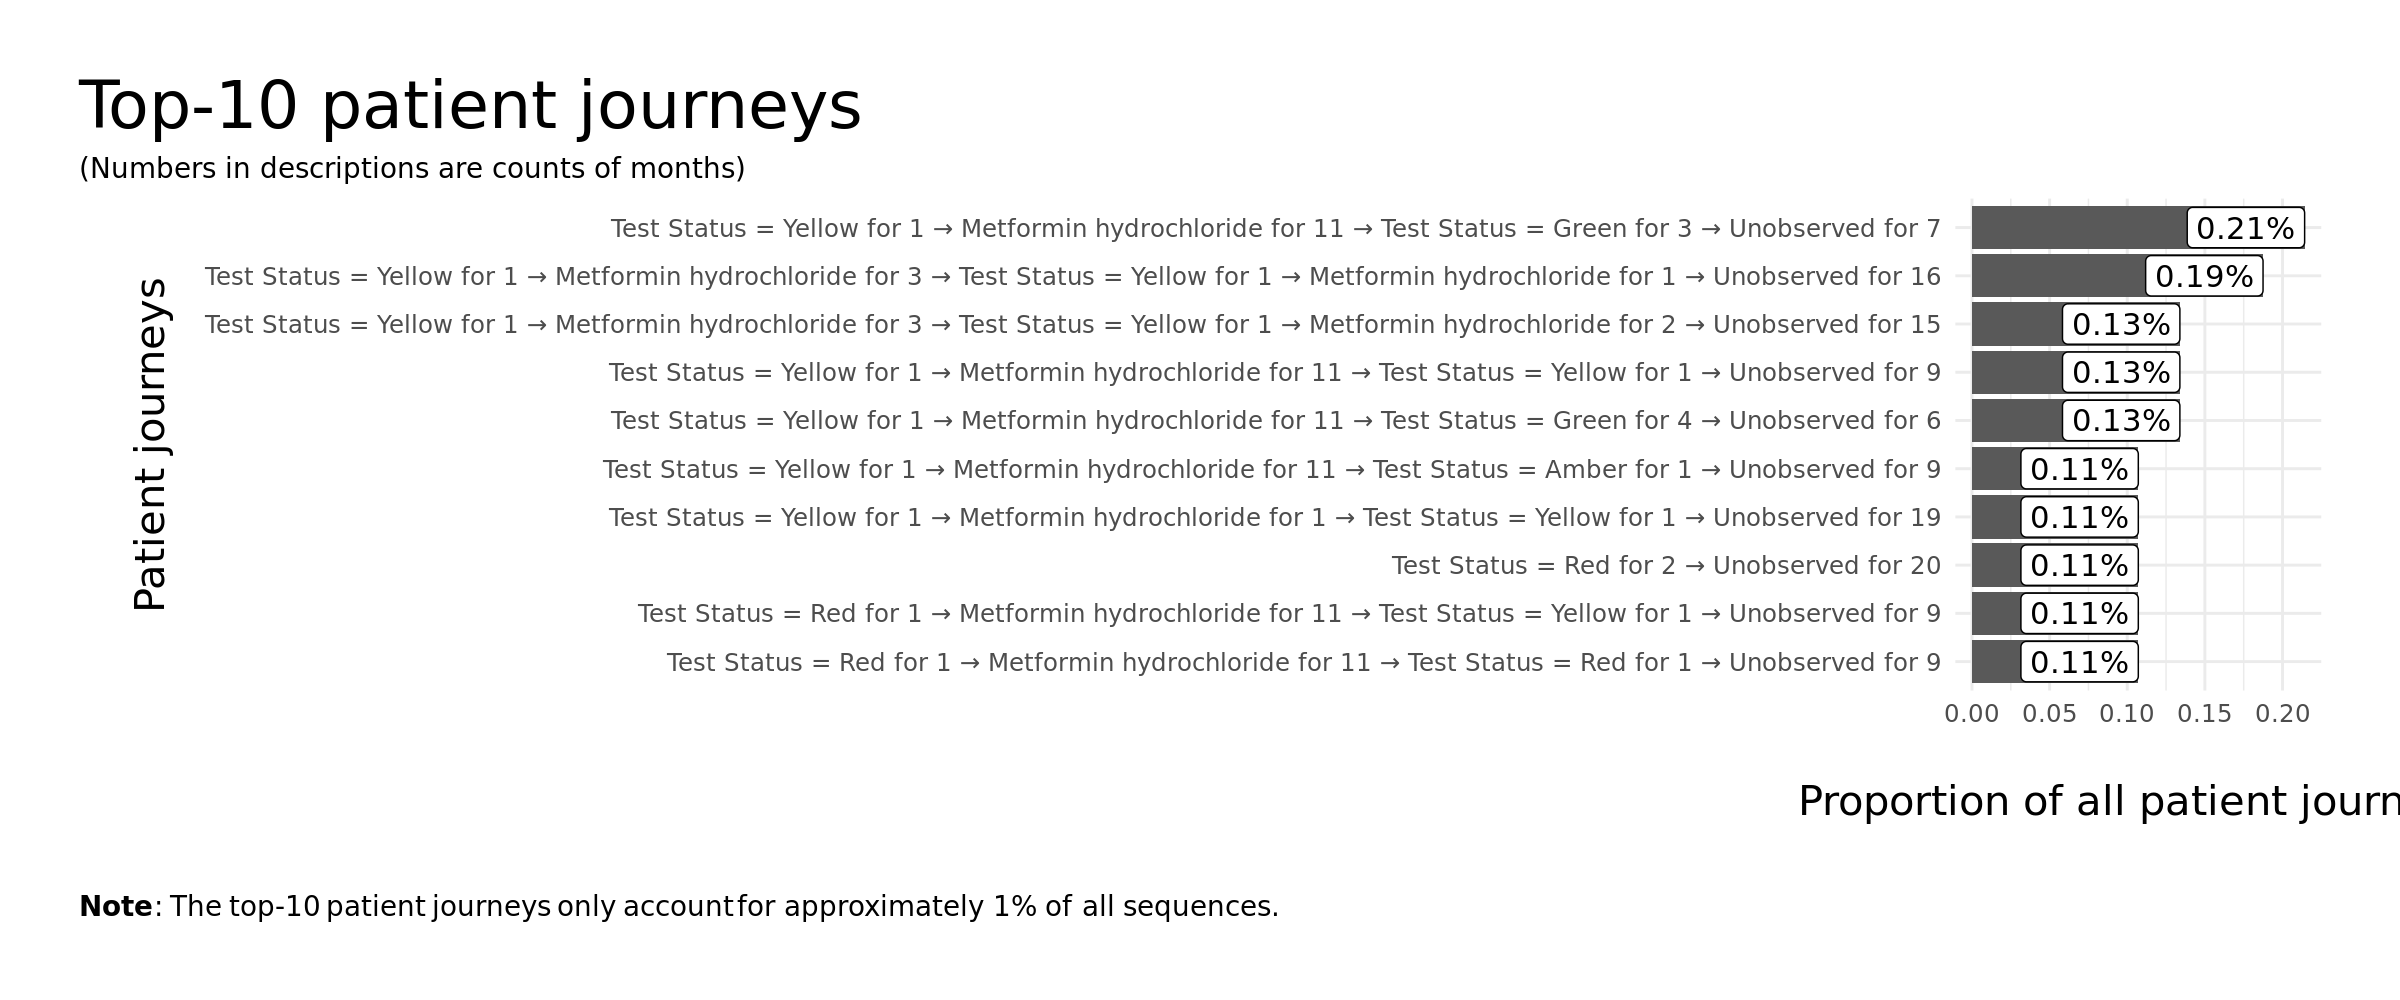

In [91]:
if ( run_process_mining_summary )
    {
        options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

        # Make plot data.
        plot_data <-
            TraMineR::seqtab( sts_seqmine ) %>%
            attributes() %>%
            purrr::pluck( "freq" ) %>%
            tibble::rownames_to_column( "sequence" ) %>%
            dplyr::arrange( desc( Freq ) ) %>%
            dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
            # Remove the leading "None/[0-9]"
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
                ) %>%
            # Replace the "-" that joins the events with an arrow.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
                ) %>%
            # Use words instead of symbols for the number of timesteps.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
                ) %>%
            suppressWarnings()


        # Plot plot data.
        plot_data %>%
            ggplot(
                aes(
                    x = reorder( sequence, Freq )
                    ,y = Percent )
                , stat = "identity"
            ) +
            geom_col() +
            geom_label(
                    aes(
                        label = Percent %>% `/`(100) %>% round(4) %>% scales::percent()
                    )
                    ,hjust = 1 ) +
            coord_flip() +
            labs(
                x = "Patient journeys"
                ,y = "Proportion of all patient journeys"
                ,title = "Top-10 patient journeys"
                ,subtitle = "(Numbers in descriptions are counts of months)"
                ,caption = paste0(
                    "**Note**: The top-10 patient journeys only account for approximately "
                    ,round( max( plot_data$cum_sum_percent ))
                           ,"% of all sequences."
                          )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = "none"
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
                ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
                )
    }

Below are the month-by-month relative propotions of each event.

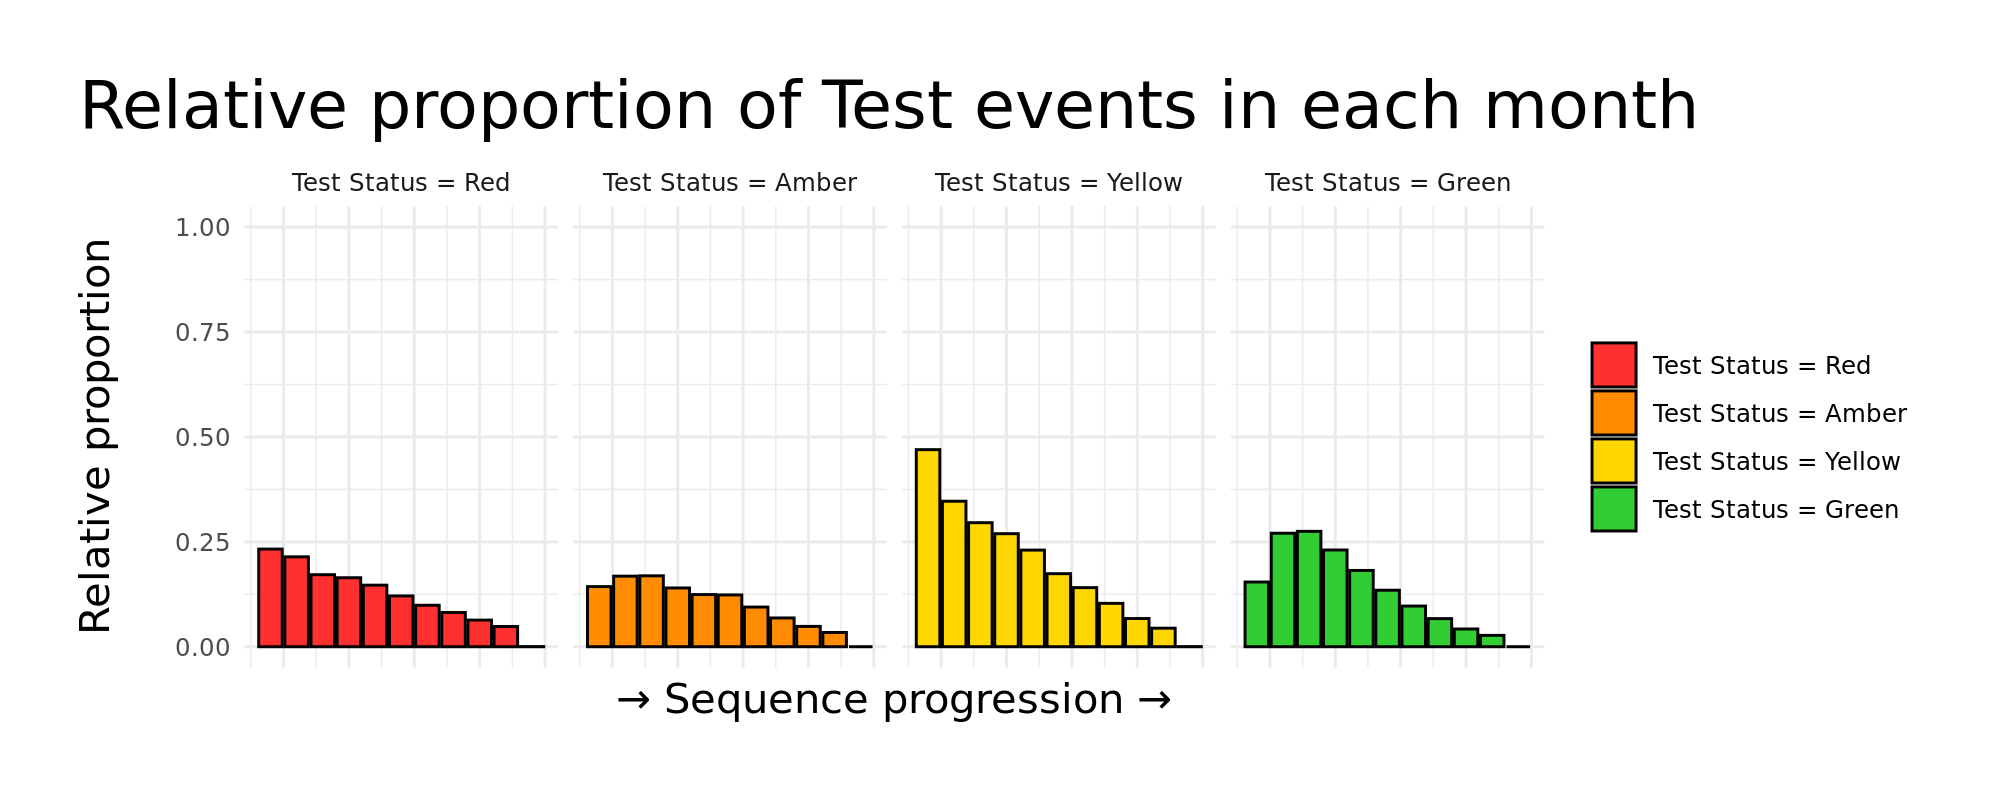

In [94]:
if ( run_process_mining_summary )
    {
    # Prepare plot data.
        plot_data <-
            TraMineR::seqstatd( sts_seqmine_test_only ) %>%
            purrr::pluck( "Frequencies" ) %>%
            as.data.frame() %>%
            tibble::rownames_to_column( "event" ) %>%
            dplyr::filter( !(event %in% c( "None", "Unobserved" ) ) ) %>%
            tidyr::pivot_longer(
                cols = !event
                ,names_to = "month"
                ,values_to = "proportion"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( event )
                ,.funs = funs( factor (., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            dplyr::mutate_at(
                .vars = vars( month )
                ,.funs = funs( stringr::str_replace_all( ., "a", "" ) %>% as.integer() )
            ) %>%
            suppressWarnings()

        # Plotting.
        options( repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200 )
        plot_relProp_TestStatuses <-
            plot_data %>%
            ggplot() +
            geom_bar(
                aes(
                    x = month
                    ,y = proportion
                    ,fill = event
                )
                ,stat = "identity"
                ,colour = "black"
            ) +
            facet_wrap( ~ event, nrow = 1) +
            scale_fill_manual( values = df_event_factor %>% dplyr::select( event_colours_order ) %>% dplyr::pull() ) +
            labs(
                x = "\u2192 Sequence progression \u2192"
                ,y = "Relative proportion"
                ,title = "Relative proportion of Test events in each month"
            ) +
            ylim(0, 1) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.x = element_blank()
                ,legend.title = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                )

        plot_relProp_TestStatuses
    }

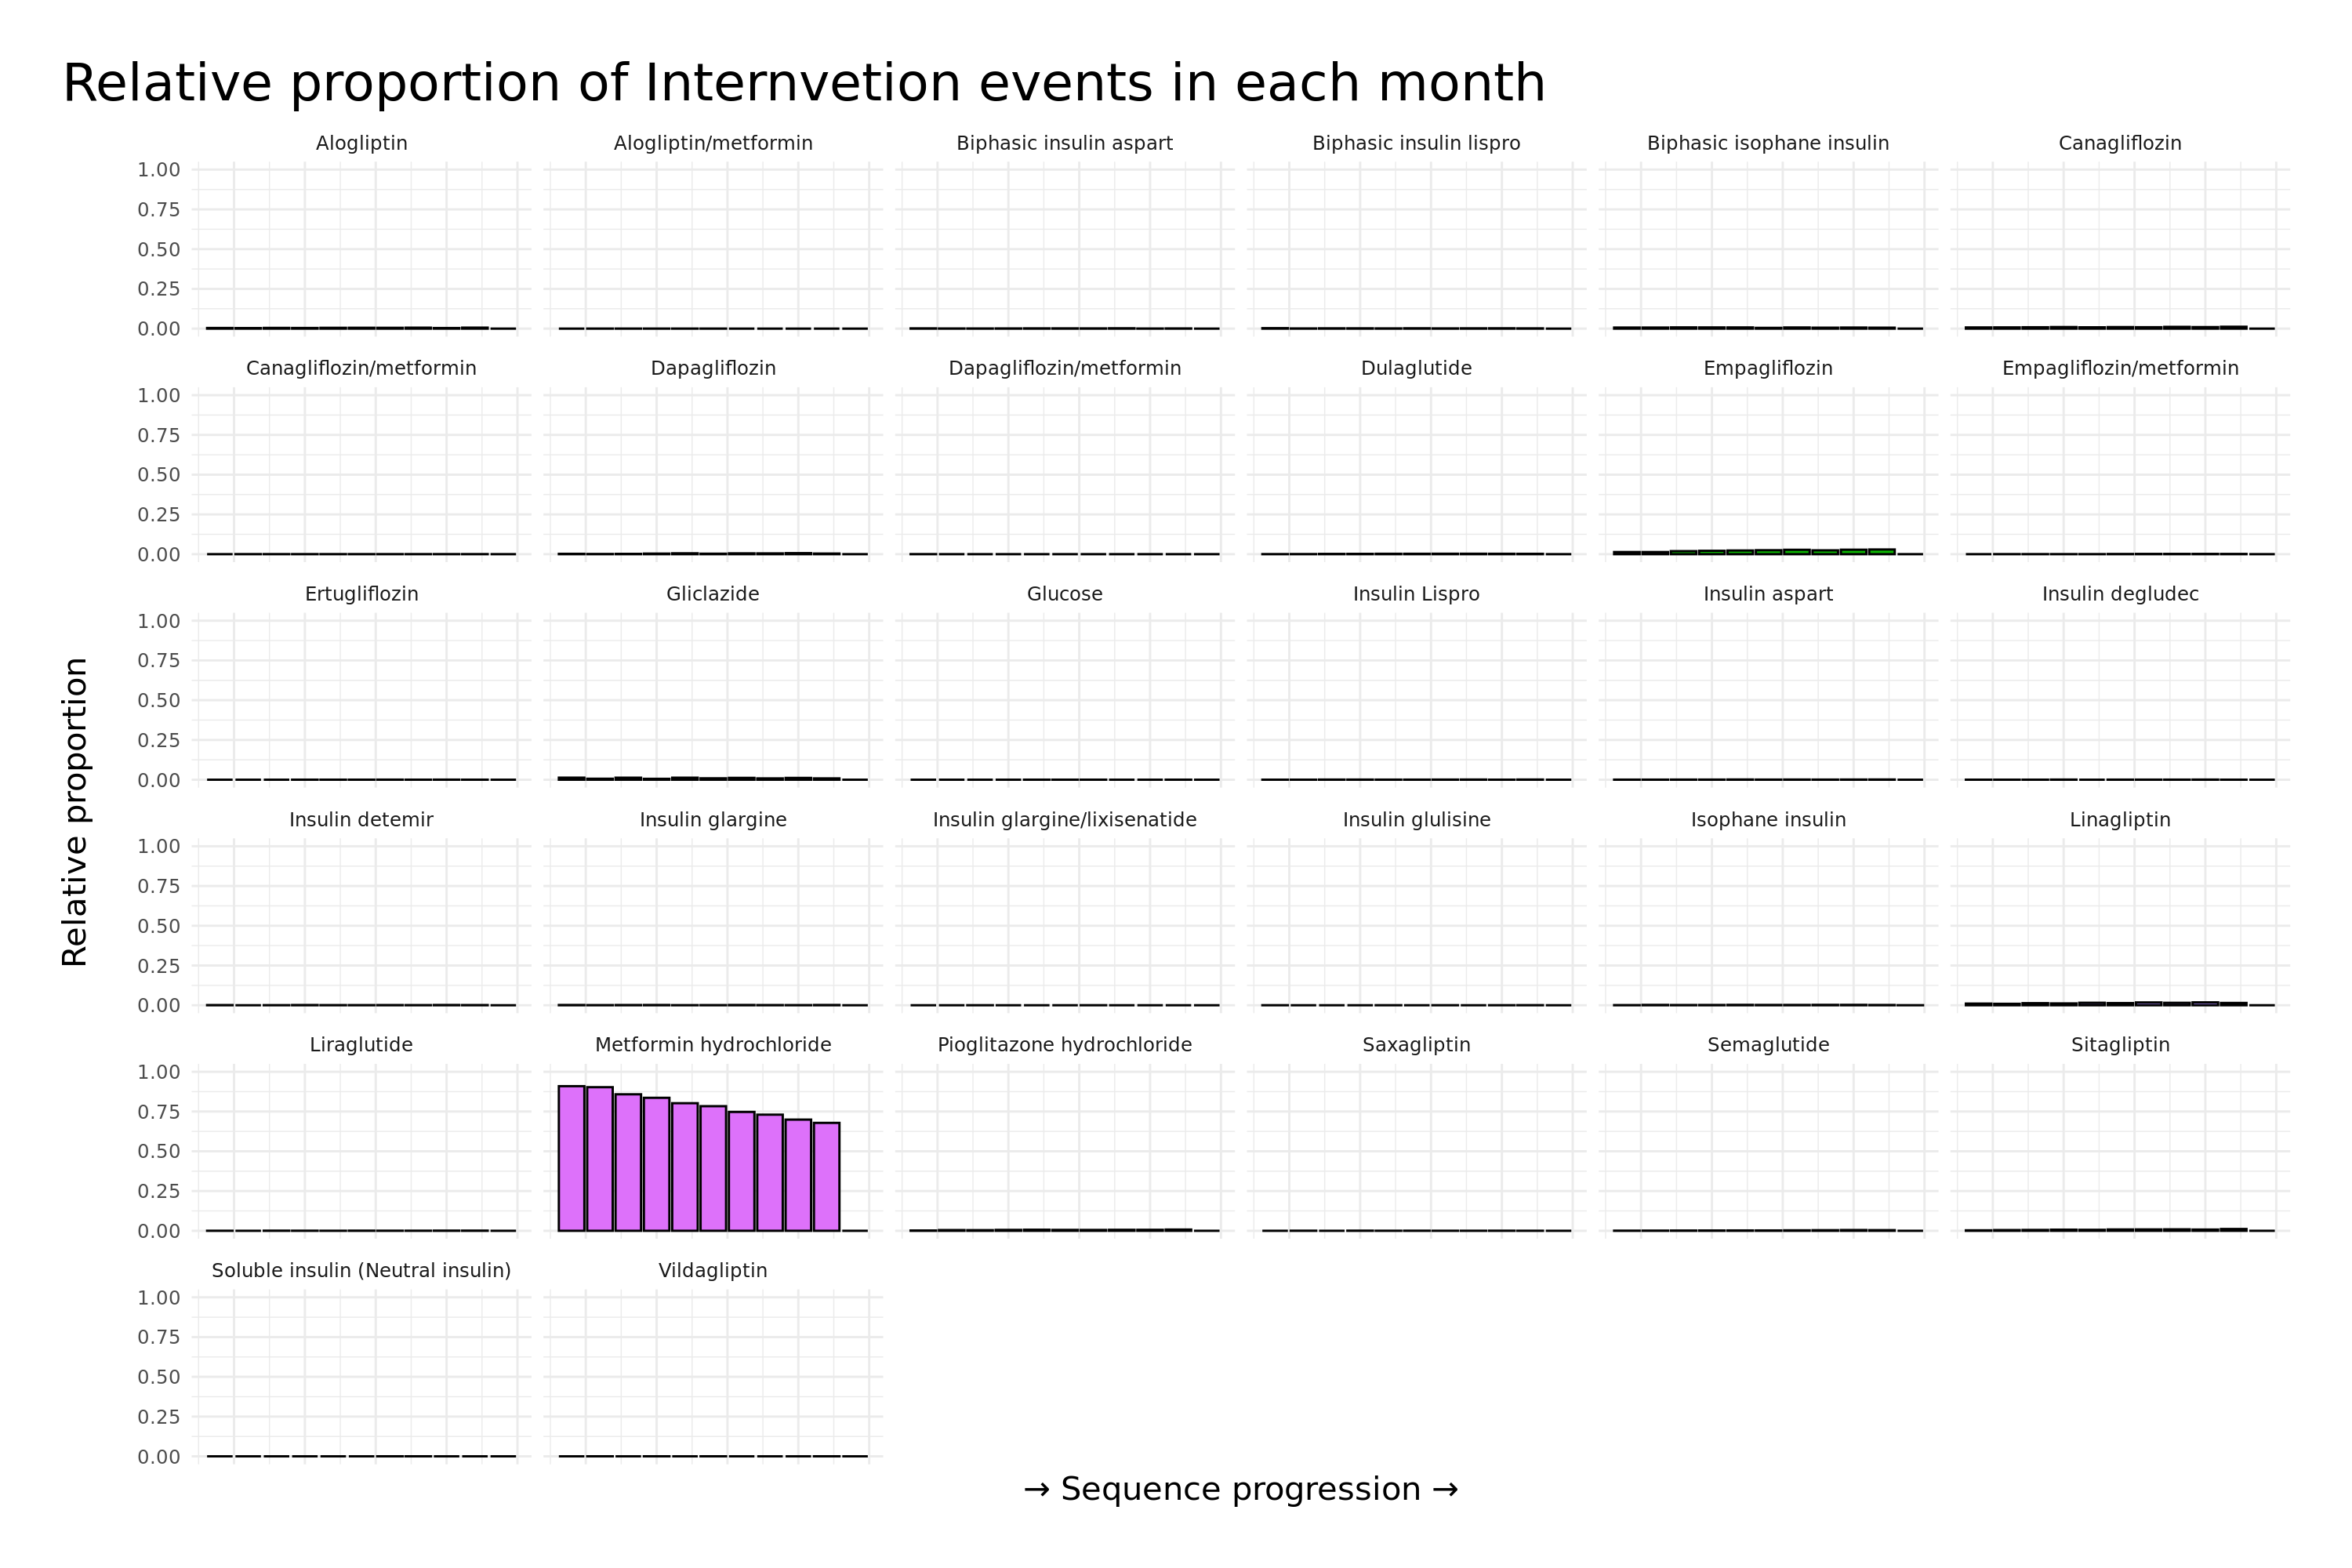

In [95]:
if ( run_process_mining_summary )
    {
        # Prepare plot data.
        plot_data <-
            TraMineR::seqstatd( sts_seqmine_intervention_only ) %>%
            purrr::pluck( "Frequencies" ) %>%
            as.data.frame() %>%
            tibble::rownames_to_column( "event" ) %>%
            dplyr::filter( !(event %in% c( "None", "Unobserved" ) ) ) %>%
            tidyr::pivot_longer(
                cols = !event
                ,names_to = "month"
                ,values_to = "proportion"
            ) %>%
            # Reorder the `event` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( event )
                ,.funs = funs( factor(., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            # Remove the "a" in the `month` variable values that were added by the TraMineR functions.
            dplyr::mutate_at(
                .vars = vars( month )
                ,.funs = funs( stringr::str_replace_all( ., "a", "" ) %>% as.integer() )
            ) %>%
            suppressWarnings()

        # Plotting.
        options( repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 200 )

        plot_relProp_Treatments <-
            plot_data %>%
            ggplot() +
            geom_bar(
                aes(
                    x = month
                    ,y = proportion
                    ,fill = event
                )
                ,stat = "identity"
                ,colour = "black"
            ) +
            facet_wrap( ~ event) +
            labs(
                x = "\u2192 Sequence progression \u2192"
                ,y = "Relative proportion"
                ,title = "Relative proportion of Internvetion events in each month"
            ) +
            ylim(0, 1) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.x = element_blank()
                ,legend.position = 'None'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                )

        plot_relProp_Treatments
    }

Average duration that a patient spends in a "state" without changing.

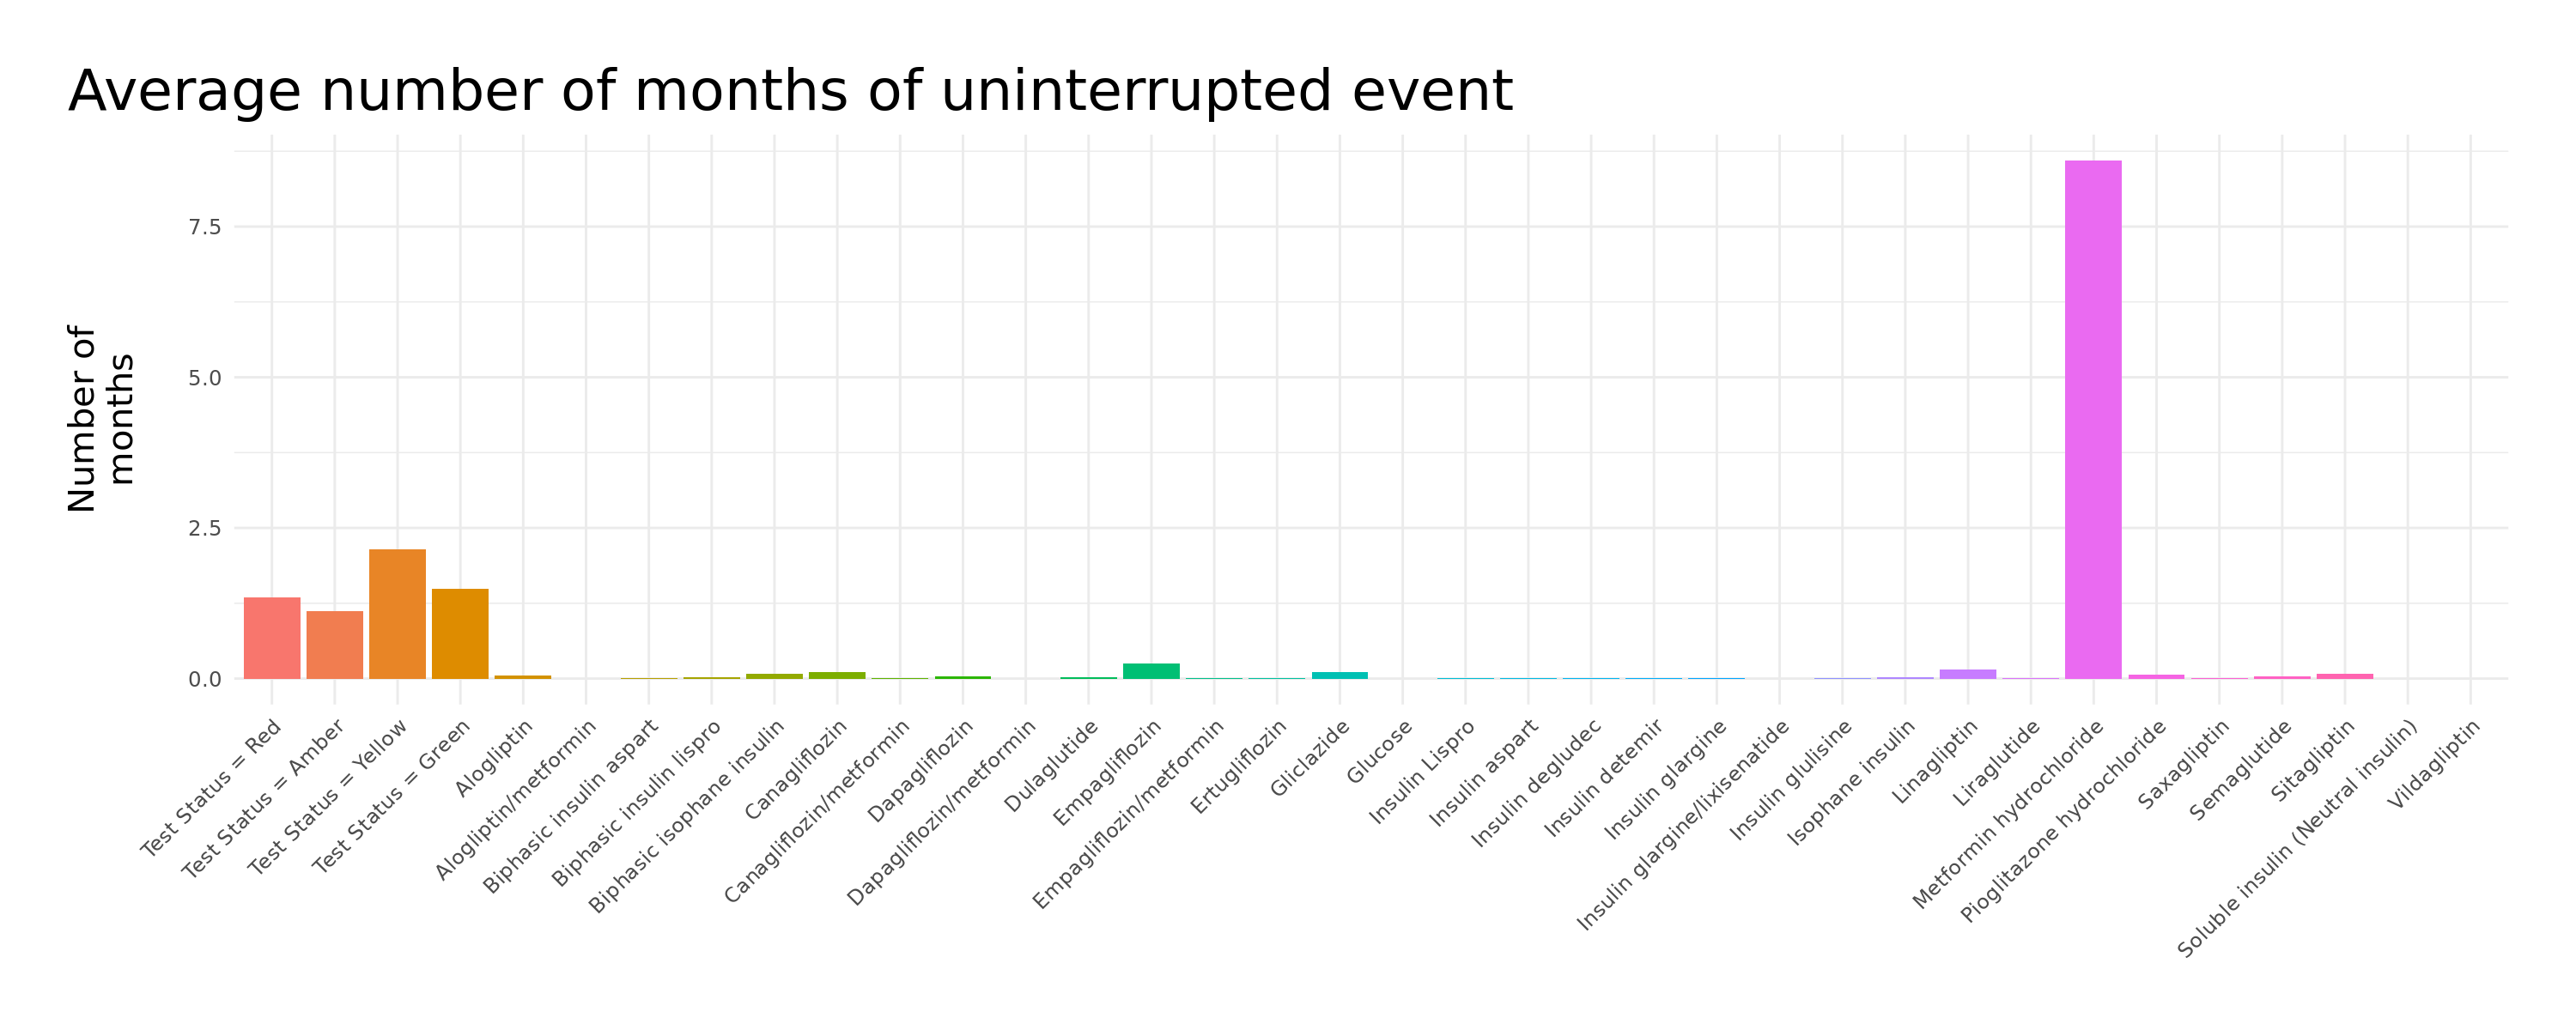

In [96]:
if ( run_process_mining_summary )
    {
        # Make plot data.
        plotData <-
            TraMineR::seqmeant( sts_seqmine ) %>%
            as.data.frame() %>%
            tibble::rownames_to_column("event") %>%
            dplyr::left_join(
                df_event_factor
                ,by = join_by( event == event_fct_order)
            ) %>%
            dplyr::mutate_at(
                .vars = vars( event )
                ,.funs = funs( factor(., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            dplyr::filter( !(event %in% c( "NA", "Unobserved" ) ) ) %>%
            suppressWarnings()


        # Plotting.
        options( repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 200 )

        plot_durationOfEvents <-
            plotData %>%
            ggplot() +
            geom_bar(
                aes(
                    x = event
                    ,y = Mean
                    ,fill = event
                )
                ,stat = "identity" ) +
            labs(
                title = "Average number of months of uninterrupted event"
                ) +
            ylab( "Number of\nmonths" ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.x = element_text( angle = 45, hjust = 1 )
                ,axis.title.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,legend.position = 'None'
                )

        plot_durationOfEvents
    }

Some initial observations of the process-mining investigation:
- __The most-common sequence patterns are dominated by intervention = 'Metformin hydrochloride' but there are too many sequence patterns for any to common in an absolute sense.__
    - Evidenced by the percentage contribution of patient journeys in the top 10.
- __The trend of descreasing test statuses over time is explained by the increase in unobserved events__
    - Evidenced by the inverselt proportional counts of test status values and the 'Unobserved' event.
- __Metformin hydrochloride is by far the most-common event across all sequences__
    - Evidenced by the relative proportion of intervention = 'Metformin hydrochloride' being more than orders of magnitude greater than other interventions.

#### Burden of Treatment / Turbulence / Complexity of care

Calculate statistics that summarise and represent the complicatedness / complexity of patients' sequences, then plot as histograms.

_Component_

- The __Transitions Count__ statistic is the count of times a patient changes state during their sequence. It has an unbounded range and does not take the length of the sequence into account (i.e. low counts can indicate short sequences with little time to change state, or can indicate a long and stable sequence).
- The __$\mathbf{log_{2}}(Subsequence Count)$__ statistic is the  $log_{2}$ of the count of 'distinct successive states' during a patient's sequence. It has an unbounded range with a sequence-specific maximum reached when the sequence cycles between all its states. Low values can indicate either few changes or a small number of unique states observed in the sequence.
- The __Longitudinal Entropy__ statistic quantifies the entropy of the distribution of durations spent in each state observed in the sequence. It is a measure of diversity of states within a sequence. It's range is between 0 and 1 because each sequence's value is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet).

_Composite_

- The __Turbulence__ statistic is the $log_{2}$ of the product of the count of subsequences and a sequence-specific scaling parameter ([Elzinga et al. 2007](https://sci-hub.wf/10.1007/s10680-007-9133-7)). The sequence-specific scaling parameter is based on the variance of observed state durations (which we know to be inversely proportional to the notion of turbulent sequences). Larger values are associated with sequences that have many states, changes, and similar durations in each state. This statistic differs from the $\mathbf{log_{2}}(Subsequence Count)$ only by the sequence-specific scaling parameter within the $log_{2}$ operator.
- The __Complexity Index__ statistic is the geometric mean of a scaled count of transitions in a sequence and the sequence's scaled longitudinal entropy ([Gabadinho et al. 2010](https://www.researchgate.net/profile/Gilbert-Ritschard/publication/220786242_Indice_de_complexite_pour_le_tri_et_la_comparaison_de_sequences_categorielles/links/53edabdb0cf26b9b7dc5f259/Indice-de-complexite-pour-le-tri-et-la-comparaison-de-sequences-categorielles.pdf)). The count of transitions is scaled to the length of the sequence, and the longitundinal entropy is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet). It's range is between 0 and 1.


Below I plot the distributions of each statistics, for various sets of states (e.g. tests only or interventions only). Upon request from the Clinical Review Board, I also provide plots stratifed where hte disrtibutinos are stratified by patient records' multimorbidity status (Green = Not multimorbidd; Red = Multimorbid).

In [ ]:
if ( run_complexity_statistics )
    {
    # Create function that will append the multimorbidity covariate.
    add.covariate <-
        function(
                df
                ,covardf = df_log_PandT_longFormat_simplified_StrataLabels
                ,covaradd = "MultiMorb"
        )
        {
        df %>%
        as.data.frame() %>%
        tibble::rownames_to_column( "person_id" ) %>%
        dplyr::mutate_at(
            .vars = vars( person_id )
            ,.funs = funs( as.integer(.) )
        ) %>%
        dplyr::left_join(
            covardf %>% 
                dplyr::filter( event_name == "diagnosis") %>%
                dplyr::select( person_id, covaradd )
            ,by = join_by( person_id )
        ) %>% suppressWarnings()
    }

    # Create function that will plot the sequence-complexity statistics.
    fnc.plot.cplx.stats.dists <-
        function(
            stsObj
            ,nbins = 20
            ,title
            ,geom = "density"
            ,strata = NULL
        )
            {

            # Make plot data.
            # ## Calculate statistics over all patient records.
            if( is.null( strata ) )
                {
                    seq_transitionCount <- TraMineR::seqtransn( stsObj )
                    seq_subsequenceCount <- TraMineR::seqsubsn( stsObj ) %>% log( base = 2 )
                    seq_longEntropy <- TraMineR::seqient( stsObj )
                    seq_turbulence <- TraMineR::seqST( stsObj )
                    seq_complexity <- TraMineR::seqici( stsObj )
                } else {
                    seq_transitionCount <- TraMineR::seqtransn( stsObj ) %>% add.covariate( covaradd = strata )
                    seq_subsequenceCount <- TraMineR::seqsubsn( stsObj ) %>% log( base = 2 ) %>% add.covariate( covaradd = strata )
                    seq_longEntropy <- TraMineR::seqient( stsObj ) %>% add.covariate( covaradd = strata )
                    seq_turbulence <- TraMineR::seqST( stsObj ) %>% add.covariate( covaradd = strata )
                    seq_complexity <- TraMineR::seqici( stsObj ) %>% add.covariate( covaradd = strata )
                }

            # Make plots.
            if(geom == "hist")
                {
                    # ## Plot histograms and summary statistics.
                    n_bins <- nbins
                    trans <-
                        seq_transitionCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Trans., fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence transition count", x = "Transition count", y = "Frequency" ) +
                        theme_classic() +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    subseq <-
                        seq_subsequenceCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Subseq., fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = base::bquote("Sequence "*log[2]("Subsequence Count")) , x = base::bquote(log[2]("Subsequence Count")), y = "Frequency" ) +
                        theme_classic() +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    entr <-
                        seq_longEntropy %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Entropy, fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence longitudinal entropy", x = "Longitudinal entropy", y = "Frequency" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    turb <-
                        seq_turbulence %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( Turbulence, fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence turbulence", x = "Turbulence score", y = "Frequency" ) +
                        theme_classic()  +
                        theme( legend.position = 'None' ) %>%
                        suppressWarnings()
                    cidx <-
                        seq_complexity %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_histogram( aes( C, fill = if( !is.null( strata ) ) { get( strata ) } ), bins = n_bins, colour = "black", position = "dodge" ) +
                        labs( title = "Sequence complexity", x = "Complexity index", y = "Frequency" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        guides( colour = guide_legend( title = strata ) ) %>%
                        suppressWarnings()
                }
            if(geom == "density")
                {
                    # ## Plot smoothed density and summary statistics.
                    trans <-
                        seq_transitionCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Trans., colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence transition count", x = "Transition count", y = "Density" ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    subseq <-
                        seq_subsequenceCount %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Subseq., colour = if( !is.null( strata ) ) { get( strata ) } )) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = base::bquote("Sequence "*log[2]("Subsequence Count")) , x = base::bquote(log[2]("Subsequence Count")), y = "Density" ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    entr <-
                        seq_longEntropy %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Entropy, colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence longitudinal entropy", x = "Longitudinal entropy", y = "Density" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    turb <-
                        seq_turbulence %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( Turbulence, colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence turbulence", x = "Turbulence score", y = "Density" ) +
                        theme_classic() +
                        theme( legend.position = 'None' )
                    cidx <-
                        seq_complexity %>%
                        tibble::as_tibble() %>%
                        ggplot() +
                        geom_density( aes( C, colour = if( !is.null( strata ) ) { get( strata ) } ) ) +
                        scale_fill_manual( values = c('limegreen', 'firebrick1') ) +
                        labs( title = "Sequence complexity", x = "Complexity index", y = "Frequency" ) +
                        xlim( 0, 1 ) +
                        theme_classic() +
                        guides( colour = guide_legend( title = strata ) )
                }
            if( !geom %in% c( "hist", "density" ) ) { stop("`geom` can only take values c( \"hist\", \"density\" ).") }

            # ## Create table of summary statistics.
            plot_table <-
                seq_transitionCount %>%
                dplyr::bind_cols( seq_subsequenceCount, seq_longEntropy, seq_turbulence, seq_complexity, .name_repair = "minimal" ) %>%
                dplyr::select(- ( contains("person_id") | contains("Multi") ) ) %>%
                dplyr::summarise(
                    across(
                        everything()
                        ,list(
                            min = min
                            ,`1st qtr` = ~quantile( ., 0.25 )
                            ,mean = mean
                            ,median = median
                            ,`3rd qtr` = ~quantile( ., 0.75 )
                            ,max = max
                        )
                    )
                ) %>%
                base::round(2) %>%
                pivot_longer(
                    everything()
                    ,names_sep = '_'
                    ,names_to = c( 'variable', '.value' )
                ) %>%
                t() %>%
                gridExtra::tableGrob( theme = gridExtra::ttheme_default( base_size = 8) )

            # ## Plot.
            options( repr.plot.width = 12, repr.plot.height = 7, repr.plot.res = 200 )
        
            myAlphabet <- stsObj %>% attributes() %>% `[[`('alphabet') 
            text_subplot <-
                paste(
                    "The state-sequence alphabet is made of"
                    ,myAlphabet %>% length()
                    ,"states."
                )
            
            plot_titles <-
                cowplot::plot_grid(
                    cowplot::ggdraw() +
                        cowplot::draw_label(
                            title
                            ,x = 0.05, y = 0.2, hjust = 0, size = 20
                        )
                    ,cowplot::ggdraw() +
                        cowplot::draw_label(
                            text_subplot
                            ,x = 0.05, y = 0.2, hjust = 0, size = 13
                        )
                    ,nrow = 3
                    ) %>%
                suppressWarnings()

            plot_plotsCombined <-
                cowplot::plot_grid(
                    trans, subseq, entr, turb, cidx, plot_table
                    ,ncol = 3
                    ) %>%
                suppressWarnings()

            plot_sequenceComplexity <-
                cowplot::plot_grid(
                    plot_titles, plot_plotsCombined
                    ,nrow = 2
                    ,rel_heights = c( 0.3, 1 )
                    )

            plot_sequenceComplexity
        }
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_allStates <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine
                ,geom = "hist"
                ,title = "Distributions of sequence-complexity statistics, across all patient records,\nusing all states."
            )
        plot_sequenceComplexity_allStates
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_allStates_stratifiedByMultiMorb <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine
                ,geom = "density"
                ,strata = "MultiMorb"
                ,title = "Smoothed densities of sequence-complexity statistics, across all patient records,\nusing all states, stratified by multimorbidity status."
            )
        plot_sequenceComplexity_allStates_stratifiedByMultiMorb
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_testStates <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_test_only
                ,geom = "hist"
                ,title = "Distribution of sequence-complexity statistics, across all patient records,\nusing test states only, stratified by multimorbidity status."
            )
        plot_sequenceComplexity_testStates
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_testStates_stratifiedByMultiMorb <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_test_only
                ,geom = "density"
                ,strata = "MultiMorb"
                ,title = "Smoothed densities of sequence-complexity statistics, across all patient records,\nusing test states only, stratified by multimorbidity status."
            )
        plot_sequenceComplexity_testStates_stratifiedByMultiMorb
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_interventionStates <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_intervention_only
                ,geom = "hist"
                ,title = "Distributions of sequence-complexity statistics, across all patient records,\nusing intervention states only."
            )
        plot_sequenceComplexity_interventionStates
    }

In [ ]:
if ( run_complexity_statistics )
    {
        plot_sequenceComplexity_interventionStates_stratifiedByMultiMorb <-
            fnc.plot.cplx.stats.dists(
                stsObj = sts_seqmine_intervention_only
                ,geom = "density"
                ,strata = "MultiMorb"
                ,title = "Smoothed densities of sequence-complexity statistics, across all patient records,\nusing intervention states only, stratified by multimorbidity status."
            )
        plot_sequenceComplexity_interventionStates_stratifiedByMultiMorb
    }

Some initial observations of the distribution plots:
- The statistics for the all-states distrbutions remain simialar to the previous iteration with only 4 intervention states (i.e. medications).
- Smoothed densities of multimorbidity states still show almost no difference bewteen multimorbid and not-multimorbid cohorts.
- Smoothed densities of multimorbidity states for intervention-only sequences still show greater density for the simple statistics of not-multimorbid cohort while showing greater density for the complicated statistics of multimorbid the cohort. I cannot explain this.

### Sankey plots

<b>Note: The Sankey plots show data that are in <u>ST</u>ate <u>S</u>equence format. This means that:</b>
1. <b>the number of sequence steps is decided by the maximum number of sequence steps observed across the dataset, _and_</b>
2. <b>a state remains unchanged in the sequence by default, rather than records being lost to follow-up.</b>
<br>
<br>
<br>
<br>



#### Test Statuses
First, I show a basic Sankey plot showing patients' test results at each testing event and visualise the proportion of patient records that switch between test statuses.

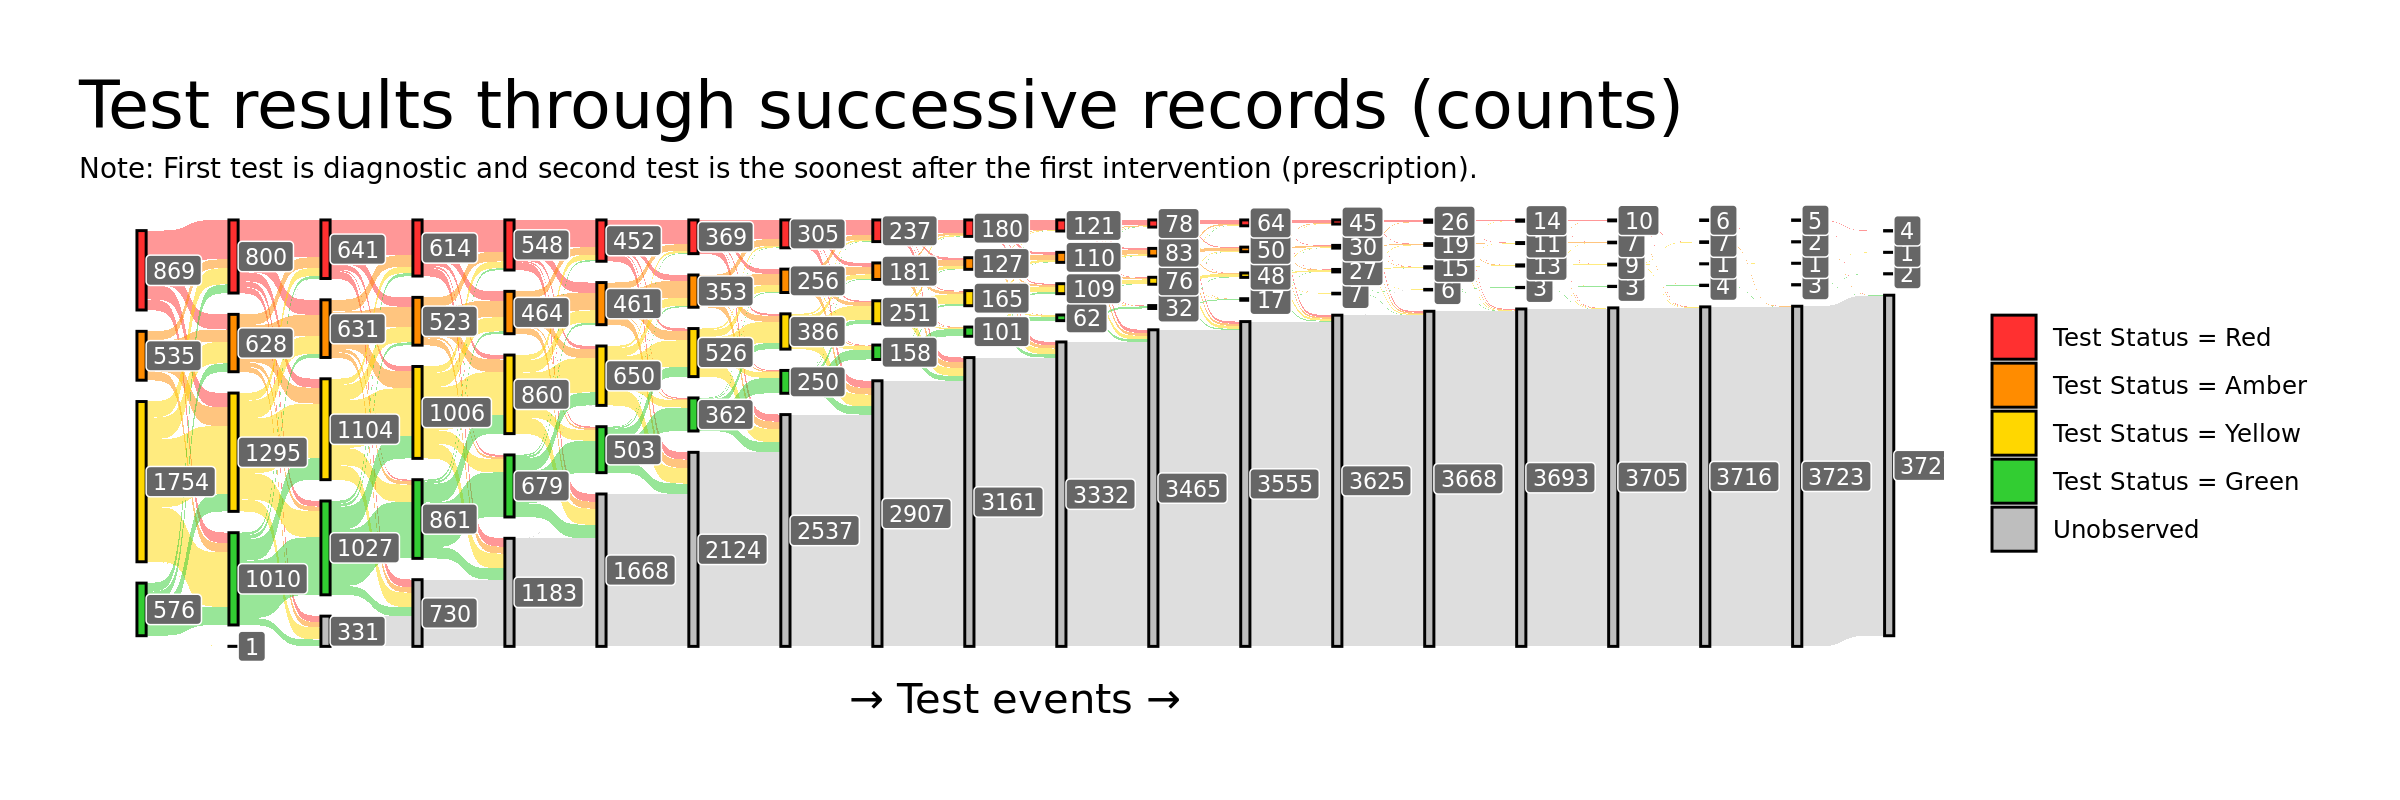

In [215]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_test_only %>%
            dplyr::select( -last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # PLot.
        options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

        plot_testStatus_Sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey( flow.alpha = 0.5, node.color = 1) +
            geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat( paste0( freq ) )
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
            labs(
                title = "Test results through successive records (counts)"
                ,subtitle= "Note: First test is diagnostic and second test is the soonest after the first intervention (prescription)."
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        plot_testStatus_Sankey
    }

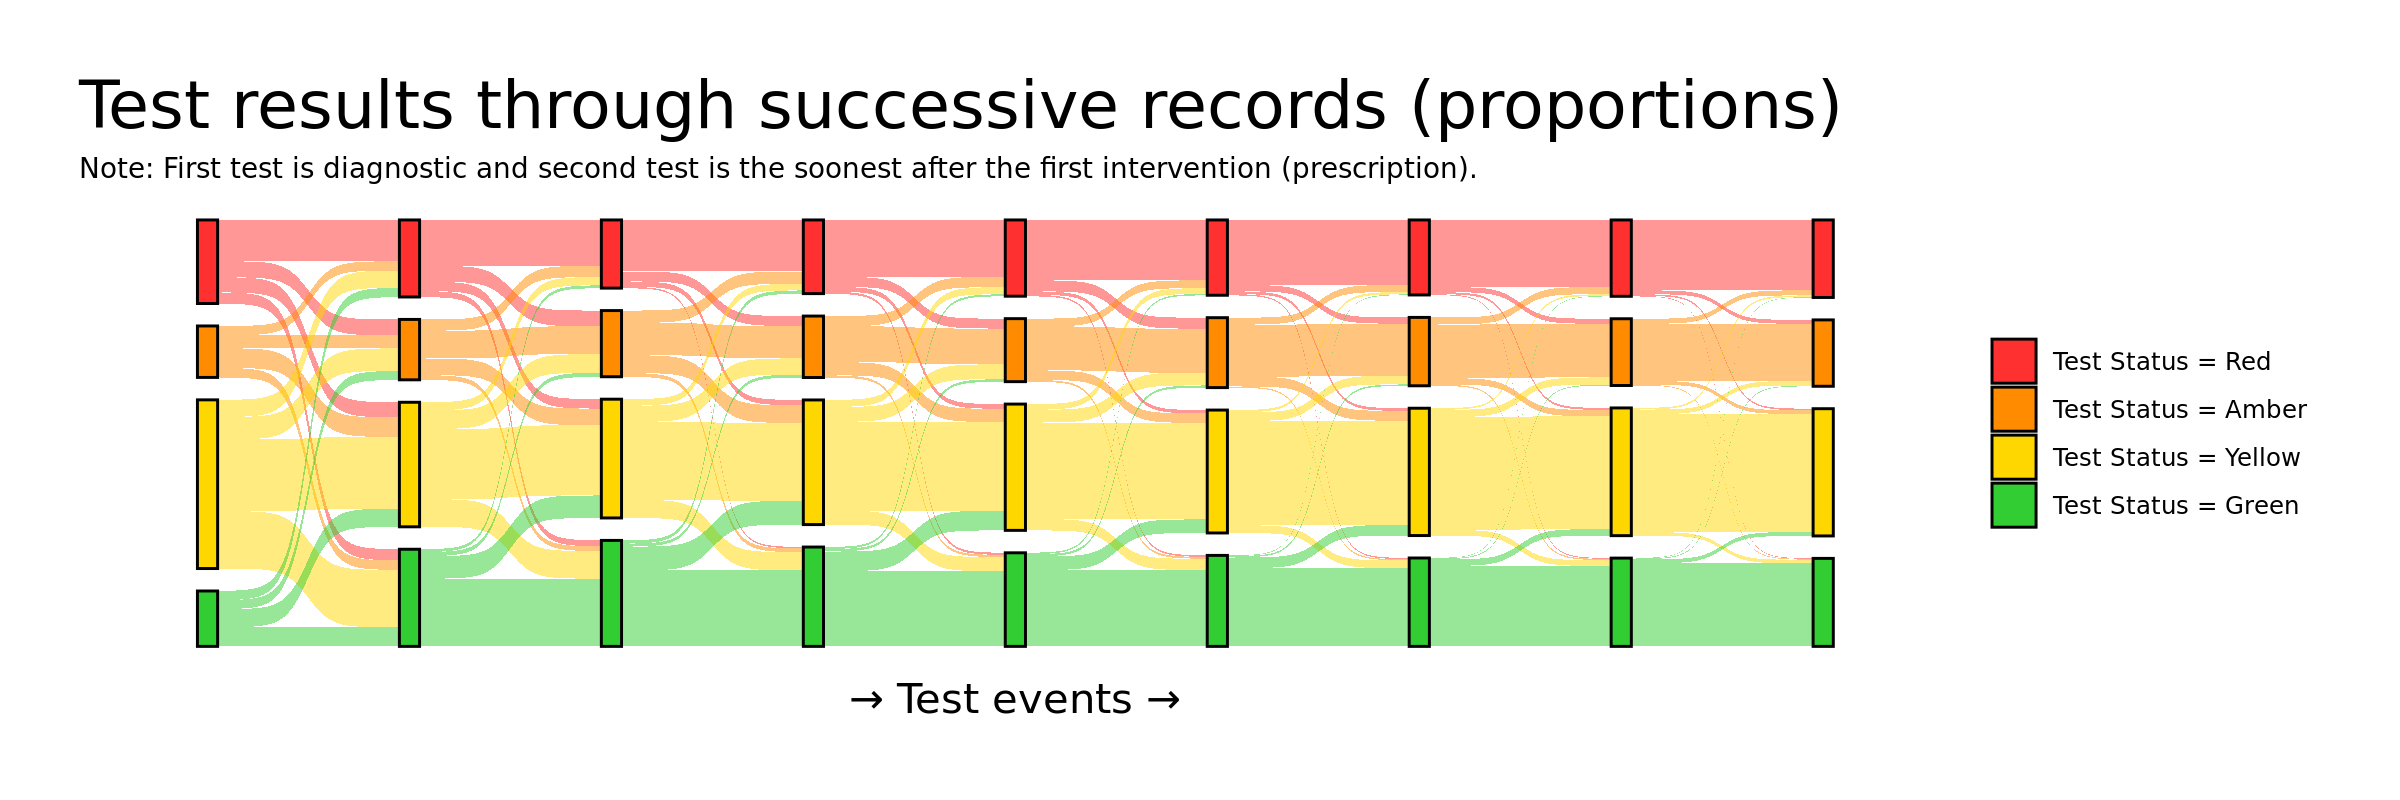

In [146]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_test_only_excludingUnobserved %>%
            dplyr::select( -last_col() ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # PLot.
        options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

        plot_testStatus_Sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey( flow.alpha = 0.5, node.color = 1) +
            scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
            labs(
                title = "Test results through successive records (proportions)"
                ,subtitle= "Note: First test is diagnostic and second test is the soonest after the first intervention (prescription)."
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        plot_testStatus_Sankey
    }

Some initial observations from the Test Statuses Sankey diagram:
1. __The overall count of patient records in each level of Test Status is approximately stable.__
    - Evidenced by little variation in the height of the vertical bars, over time.
2. __Patient records indicating a particular Test Status level predominantly stay in that Test Status level.__
    - Evidenced by the largest ribbon joining subsequent vertical bars almost exclusively comes from the the same Test Status level.
3. __The Test Status levels that change between every test event rarely change by more than one level.__
    - Evidenced by many ribbons linking vertically-adjacent bars at subsequent test points.

In the meeting of the wider project team at the end of the previous iteration, there was a request to view how individual records progress between the strata of the variable (a.k.a. the lanes) and across the events. The plot below shows the progression of a randomly-selected group of records. The random selection is taken every time the plot is rendered, and the count of records being selected can be set with the `n_records_to_sample` pareameter at the start of the code block. Note that he veritcal 'jitter' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.

In [ ]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 10

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_test_only %>%
            dplyr::select( -last_col() ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            )  %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_event_factor %>%
            dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>%
            dplyr::select( event_fct_order ) %>%
            droplevels() %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Plot
        options( repr.plot.width = 12, repr.plot.height = 4.5, repr.plot.res = 200 )

        plot_laneSwitching_Tests <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 2.5, yend = 2.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 3.5, yend = 3.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 4.5, yend = 4.5, linewidth = 3, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences %>% dplyr::mutate( grp =  rep(1:n_records_to_sample, each = n_iterations) )
                ,aes(
                    x = variable
                    ,y = value
                    ,group = grp
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) | event_fct_order == "Unobserved" ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = stringr::str_wrap( "\"Lane switching\" of randomly-selected sequences of successive records: Test Status", width = 60 )
                ,x = "\u2192 Test events \u2192"
                ,caption = 
                    paste0(
                        "**Note 1:** A new set of records will be selected every time this plot is rendered.\n\n"
                        ,"**Note 2:** Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,legend.box.margin = margin( t = 1, r = 1, l = 2, b = 1, unit =  "cm")
                ,legend.key = element_rect( colour = 'black', size = 1 )
                ,plot.margin = margin( t = 1, r = 0, l = 1, b = 1, unit =  "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_text( colour = 'white', size = 5)
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                ) %>%
            suppressWarnings()

        plot_laneSwitching_Tests
    }

In [ ]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_test_only ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

#### H.M.A. strata

In the next plot, the Sankey plot visualises the proportions of patient records moving between strata of the H.M.A. stratification.

H.M.A. stratification is something CB proposed. It has four strata infomed by two components: the testing interval since the previous test {'Expected', 'Shorter-than-expected'}, and the change in prescriptions compared with the previous testing interval {'No observed change', 'Observed change'}. The stratification gets its name from the four strata: (0,0)-Run; (1,0)-Monitor; (0 or 1,1)-Adjust.

The first task is to create a new state-sequence object that tracks H.M.A. strata.

In [276]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Define list of events to focus on.
        events_selection <-
            df_HMA_factor %>%
            dplyr::select( HMA_fct_order ) %>%
            droplevels() %>%
            dplyr::pull()

        # Create the data transition matrix.
        stm_HMA <-
            events_selection %>%
            rep(.,  times = length(.) ) %>%
            matrix( nrow = sqrt( length(.) ), byrow = TRUE ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind(.[1,], .)
        rownames( stm_HMA )[1] <- 'None'

        # Convert the time series dataframe to a state sequence object.
        sts_seqmine_HMA <-
            TraMineRextras::TSE_to_STS(
                df_seq_test_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "HMA"
                ,stm = stm_HMA
                ,tmax = df_seq_test_only %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            TraMineR::seqdef( labels = c('None', events_selection ) ) %>%
            suppressMessages()
    }

In [248]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Define list of events to focus on.
        events_selection <-
            df_HMA_factor %>%
            dplyr::select( HMA_fct_order ) %>%
            dplyr::filter( HMA_fct_order != "Unobserved" ) %>%
            droplevels() %>%
            dplyr::pull()

        # Create the data transition matrix.
        stm_HMA_excludingUnobserved <-
            events_selection %>%
            rep(.,  times = length(.) ) %>%
            matrix( nrow = sqrt( length(.) ), byrow = TRUE ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind(.[1,], .)
        rownames( stm_HMA_excludingUnobserved )[1] <- 'None'

        # Convert the time series dataframe to a state sequence object.
        sts_seqmine_HMA_excludingUnobserved <-
            TraMineRextras::TSE_to_STS(
                df_seq_test_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "HMA"
                ,stm = stm_HMA_excludingUnobserved
                ,tmax = df_seq_test_only_excludingUnobserved %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            TraMineR::seqdef( labels = c('None', events_selection ) ) %>%
            suppressMessages()
    }

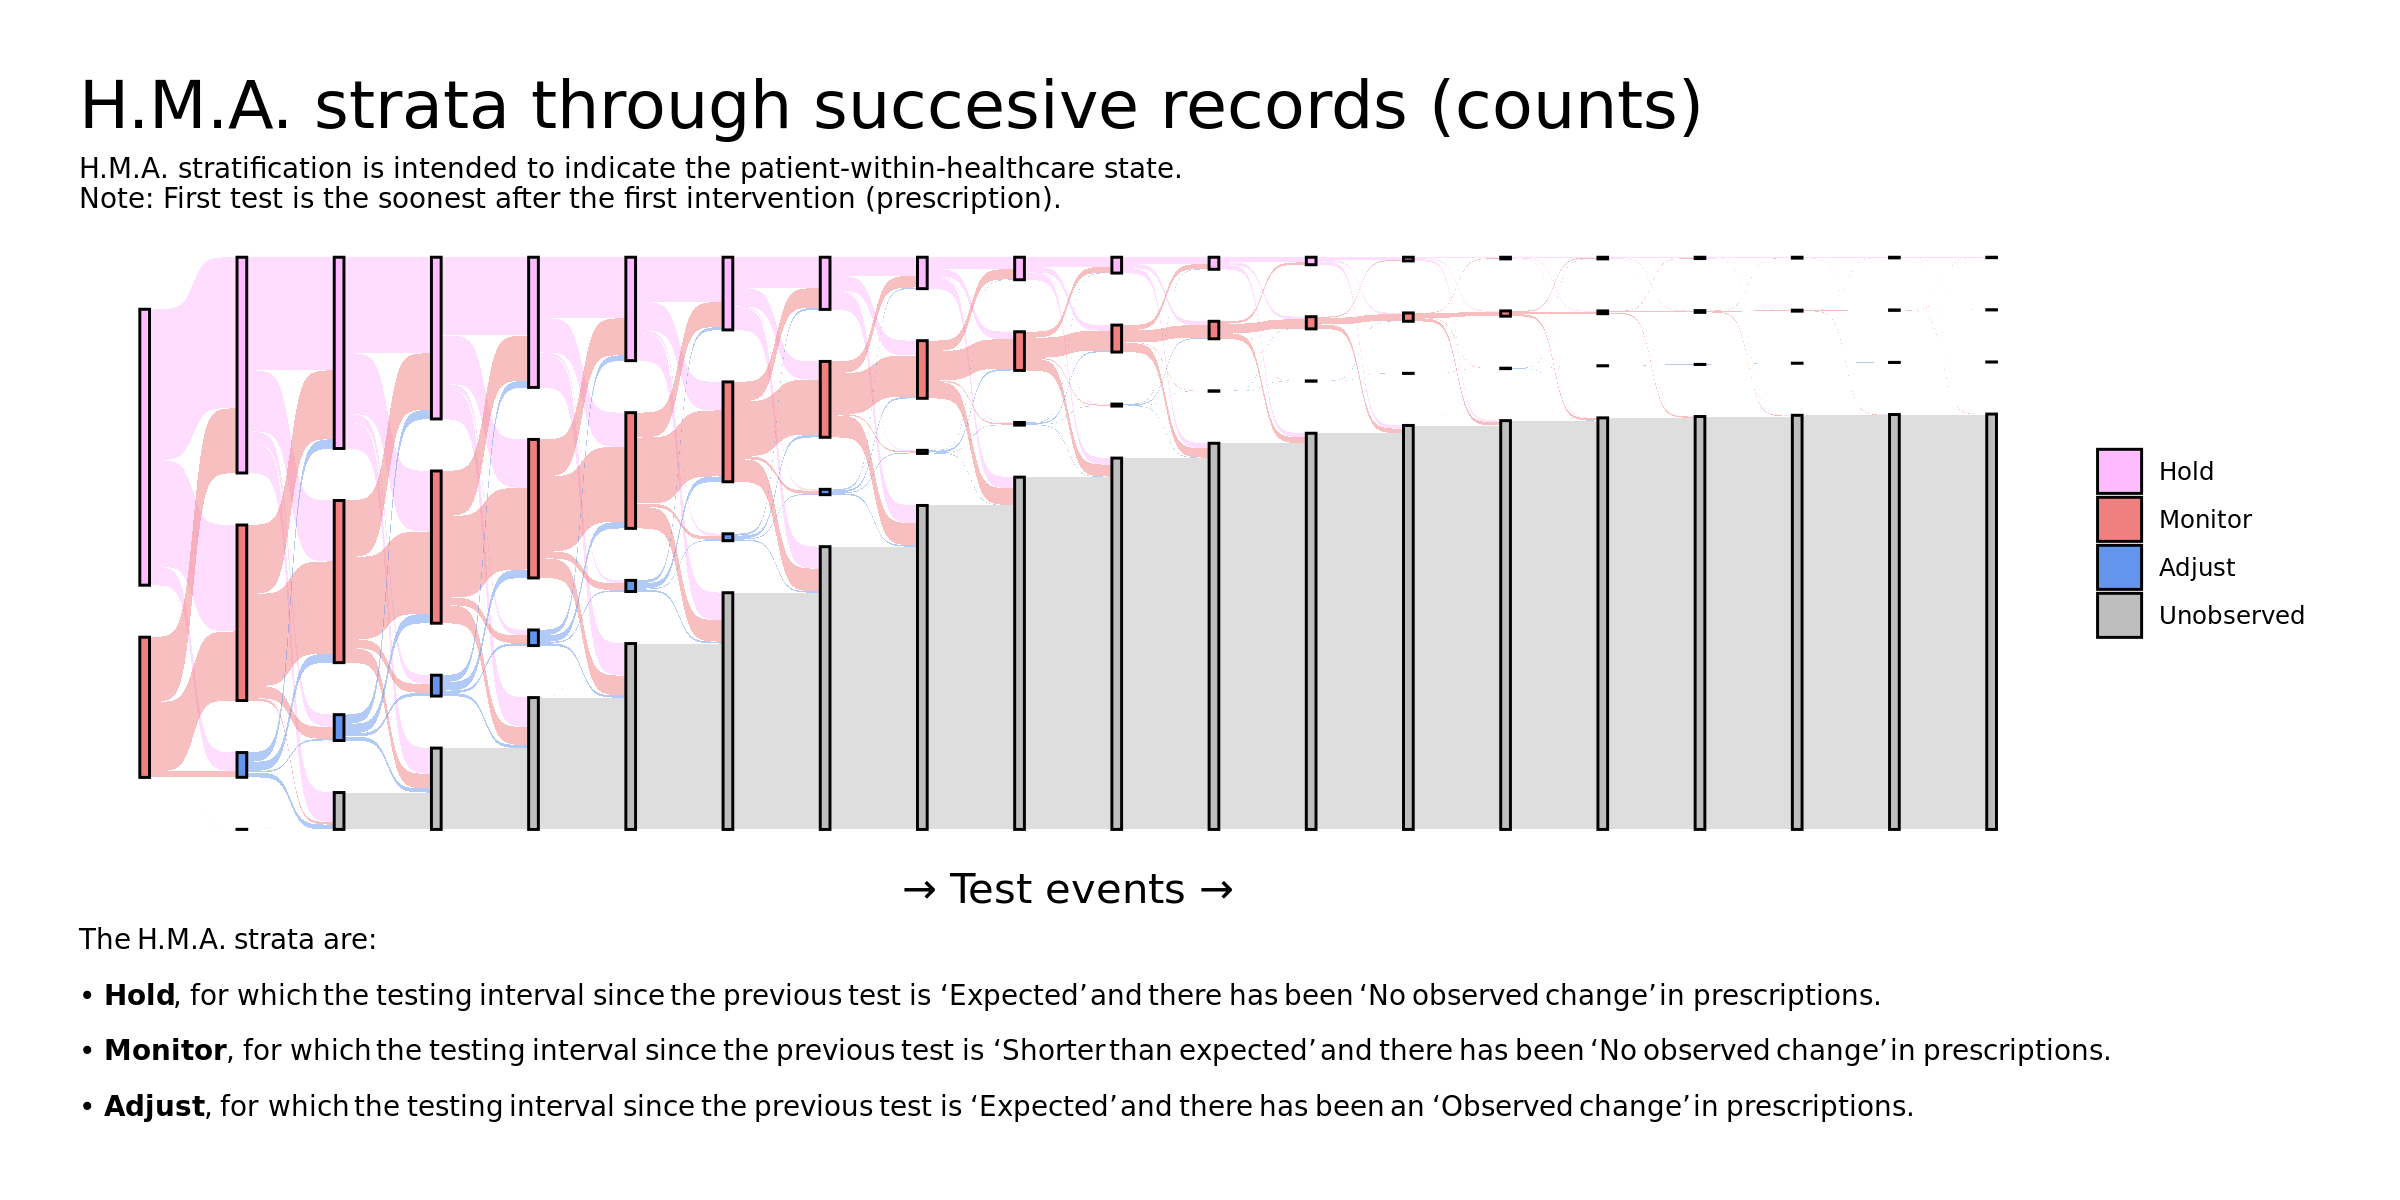

In [277]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMA %>%
            dplyr::select( - c( a1, last_col() ) ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Plot.
        options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

        plot_HMA_Sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey( flow.alpha = 0.5, node.color = 1) +
            #geom_sankey_label(
            #    aes(
            #      x = as.numeric(x) + .05,
            #      label = after_stat(paste0(freq))
            #    ),
            #    size = 8 / .pt, color = "white", fill = "gray40",
            #    hjust = 0
            #  ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull() ) +
            labs(
                title = "H.M.A. strata through succesive records (counts)"
                ,subtitle = paste0(
                    "H.M.A. stratification is intended to indicate the patient-within-healthcare state."
                    ,"\nNote: First test is the soonest after the first intervention (prescription)."
                )
                ,x = "\u2192 Test events \u2192"
                ,caption = paste0(
                    "The H.M.A. strata are:<br><br>"
                    ,"\u2022 **Hold**, for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Monitor**, for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Adjust**, for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                ,legend.title = element_blank()
                )

        plot_HMA_Sankey
    }

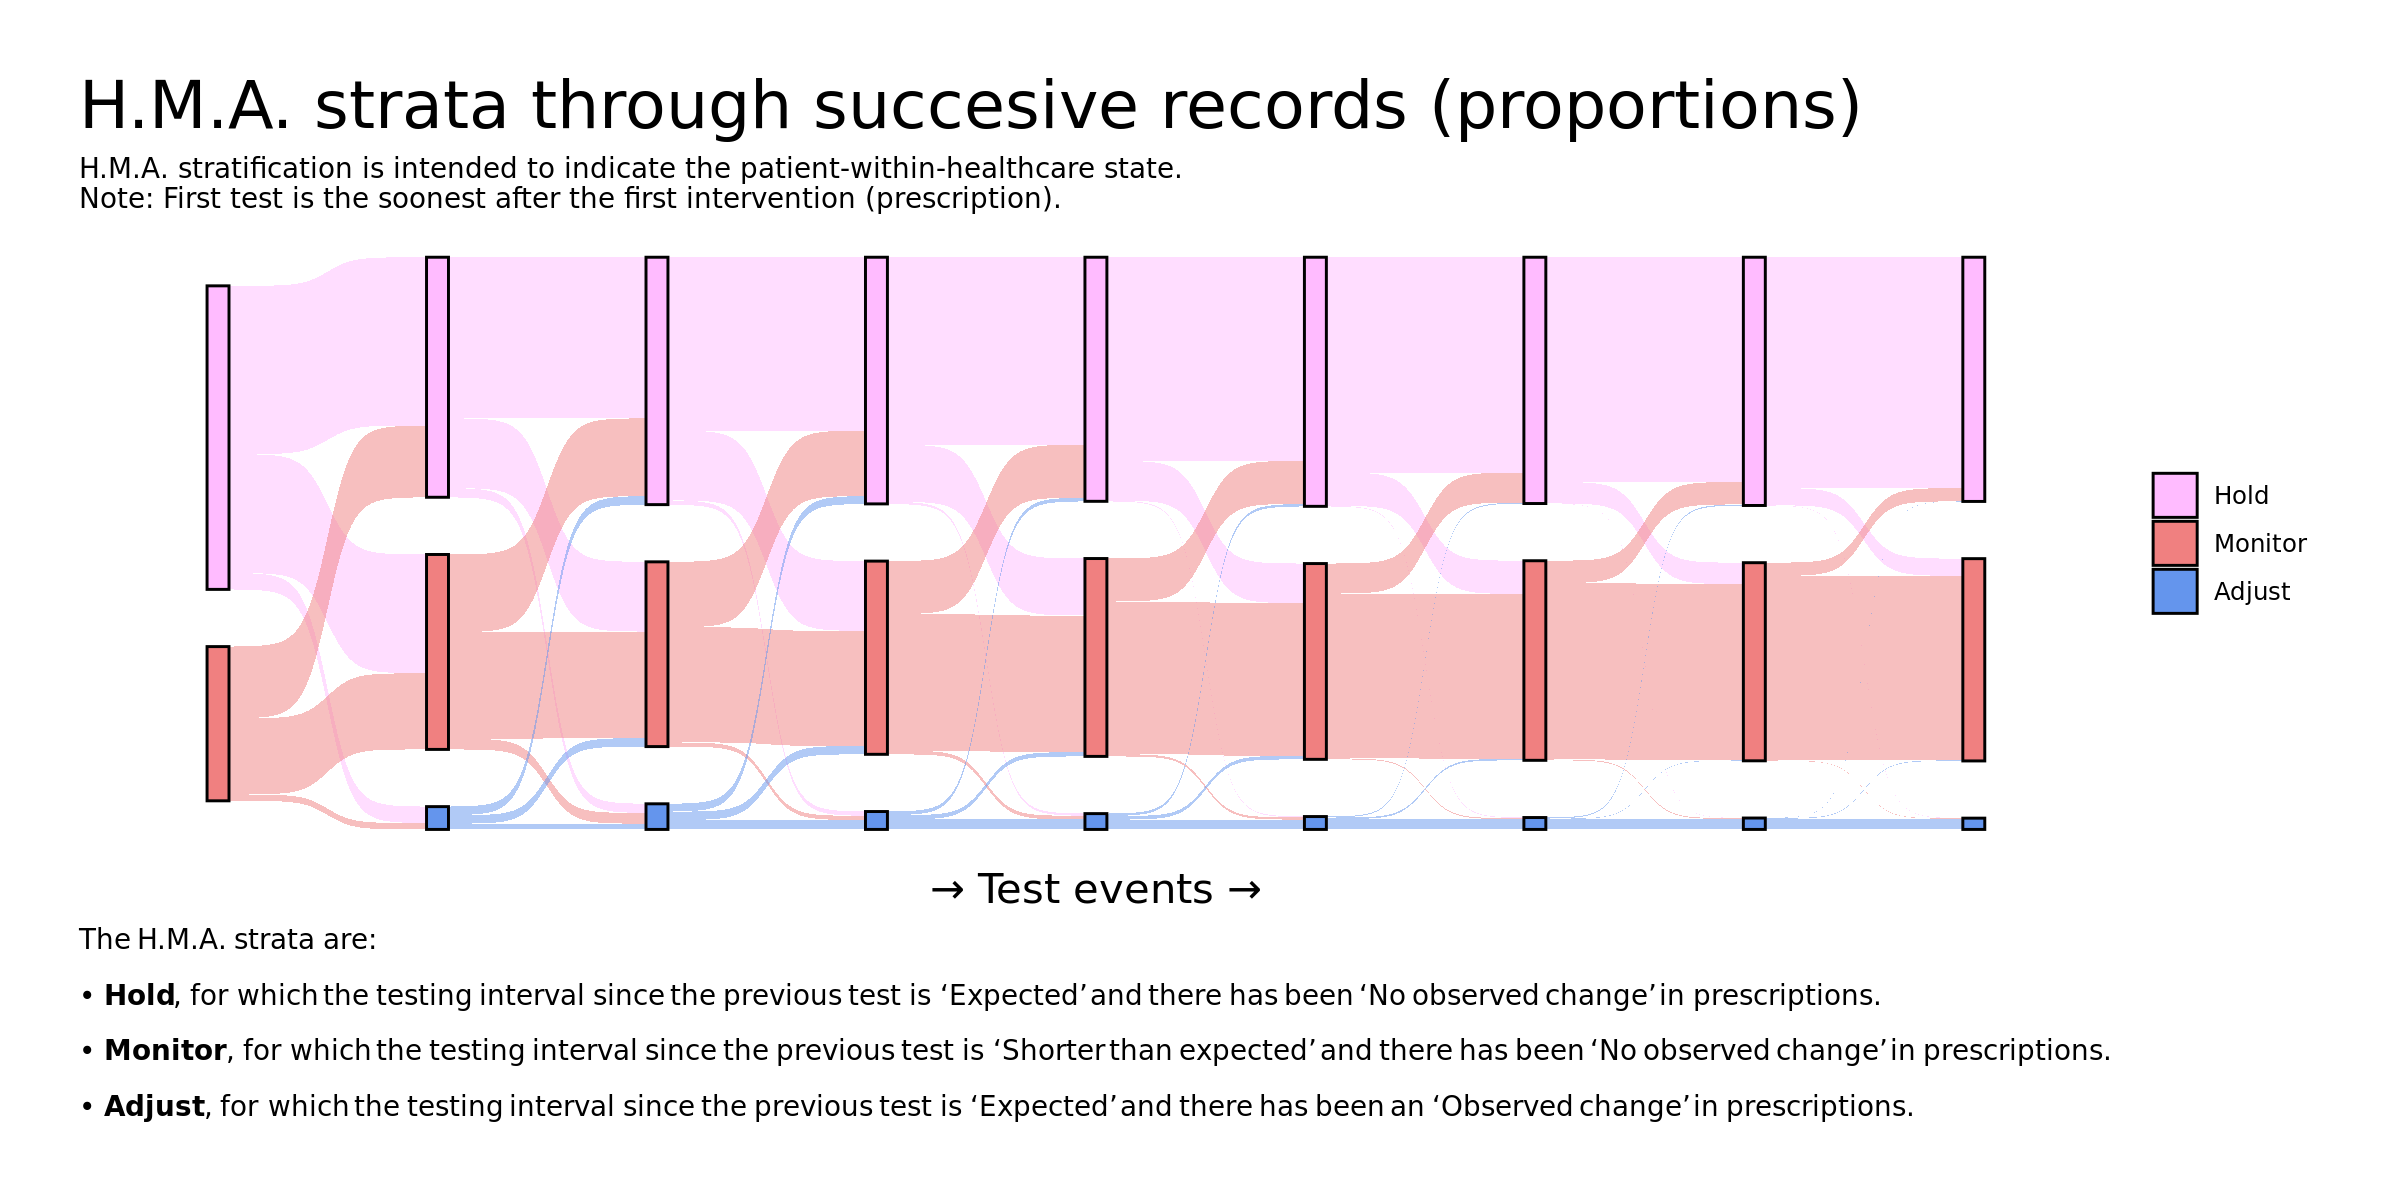

In [249]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMA_excludingUnobserved %>%
            dplyr::select( - c( a1, last_col() ) ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMA_factor %>% dplyr::distinct( HMA_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Plot.
        options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

        plot_HMA_Sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey( flow.alpha = 0.5, node.color = 1) +
            
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull() ) +
            labs(
                title = "H.M.A. strata through succesive records (proportions)"
                ,subtitle = paste0(
                    "H.M.A. stratification is intended to indicate the patient-within-healthcare state."
                    ,"\nNote: First test is the soonest after the first intervention (prescription)."
                )
                ,x = "\u2192 Test events \u2192"
                ,caption = paste0(
                    "The H.M.A. strata are:<br><br>"
                    ,"\u2022 **Hold**, for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Monitor**, for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.<br><br>"
                    ,"\u2022 **Adjust**, for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                ,legend.title = element_blank()
                )

        plot_HMA_Sankey
    }

Some initial observations from the H.M.A. Sankey diagram:
1. __Most patient records indicate a 'Run' strategy at first, but the 'Monitor' strategy prevails for those records that are longer.__
    - Evidenced by the 'Run' vertical bars being the largest, initially, but the 'Monitor' vertical bars being largest, at the end.
3. __Very few patient records indicate the undesirable category of 'Adjust'.__
    - Evidenced by the barely visible vertical bars that represent the counts of patients in the 'Adjust' category.

In the meeting of the wider project team at the end of the previous iteration, there was a request to view how individual records progress between the strata of the variable (a.k.a. the lanes) and across the events. The plot below shows the progression of a randomly-selected group of records. The random selection is taken every time the plot is rendered, and the count of records being selected can be set with the `n_records_to_sample` pareameter at the start of the code block. Note that he veritcal 'jitter' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.

In [ ]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 10

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_HMA %>%
            dplyr::select( - ( a1, a2, last_col() ) ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            )  %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_HMA_factor %>%
            dplyr::select( HMA_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Plot
        options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

        plot_laneSwitching_HMA <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 2.5, yend = 2.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 3.5, yend = 3.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 4.5, yend = 4.5, linewidth = 3, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences %>% dplyr::mutate( grp =  rep(1:n_records_to_sample, each = n_iterations) )
                ,aes(
                    x = variable
                    ,y = value
                    ,group = grp
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_HMA_factor %>% dplyr::select( HMA_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = stringr::str_wrap( "\"Lane switching\" of randomly-selected sequences of successive records: H.M.A. category", width = 60 )
                ,x = "\u2192 Test events \u2192"
                ,caption = 
                    paste0(
                        "**Note 1:** A new set of records will be selected every time this plot is rendered.<br><br>"
                        ,"**Note 2:** Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.<br><br>"
                        ,"The H.M.A. strata are:<br><br>"
                        ,"\u2022 **Hold**, for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.<br><br>"
                        ,"\u2022 **Monitor**, for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.<br><br>"
                        ,"\u2022 **Adjust**, for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions."
                    )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,legend.title = element_blank()
                ,legend.box.margin = margin( t = 1, r = 1, l = 2, b = 1, unit =  "cm")
                ,legend.key = element_rect( colour = 'black', size = 1 )
                ,plot.margin = margin( t = 1, r = 0, l = 1, b = 1, unit =  "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_text( colour = 'white', size = 12)
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()

                )

        plot_laneSwitching_HMA
}

In [ ]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_HMA ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

In [ ]:
if ( run_process_mining_summary )
    {
        options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

        # Make plot data.
        plot_data <-
            TraMineR::seqtab( sts_seqmine_HMA ) %>%
            attributes() %>%
            purrr::pluck( "freq" ) %>%
            tibble::rownames_to_column( "sequence" ) %>%
            dplyr::arrange( desc( Freq ) ) %>%
            dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
            # Remove the leading "None/[0-9]"
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
                ) %>%
            # Replace the "-" that joins the events with an arrow.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
                ) %>%
            # Use words instead of symbols for the number of timesteps.
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
                ) %>%
            # Repalce "Unobserved for [0-9]*" with "End".
            dplyr::mutate_at(
                .vars = vars( sequence )
                ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
                ) %>%
            suppressWarnings()


        # Plot plot data.
        plot_data %>%
            ggplot(
                aes(
                    x = reorder( sequence, Freq )
                    ,y = Percent )
                , stat = "identity"
            ) +
            geom_col() +
            geom_label(
                    aes(
                        label = Percent %>% `/`(100) %>% round(4) %>% scales::percent()
                    )
                    ,hjust = 1 ) +
            coord_flip() +
            labs(
                x = "Patient journeys"
                ,y = "Proportion of all patient journeys"
                ,title = "Top-10 patient journeys: H.M.A. status"
                ,subtitle = "(Numbers in descriptions are counts of months)"
                ,caption = paste0(
                    "**Note**: The top-10 patient journeys only account for approximately "
                    ,round( max( plot_data$cum_sum_percent ))
                           ,"% of all H.M.A. sequences."
                          )
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 10 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = "none"
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
                ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
                )
    }

#### H.M.A. and Test Status strata

In the next plot, the Sankey plot visualises the proportions of patient records moving through test statues and H.M.A. category.

The first task is to create a new state-sequence object that tracks `HMAandTestStatus` strata.

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Define list of events to focus on.
        events_selection <-
            df_HMAandTestStatus_factor %>%
            dplyr::select( HMAandTestStatus_fct_order ) %>%
            droplevels() %>%
            dplyr::pull()

        # Create the data transition matrix.
        stm_HMAandTestStatus <-
            events_selection %>%
            rep(.,  times = length(.) ) %>%
            matrix( nrow = sqrt( length(.) ), byrow = TRUE ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind(.[1,], .)
        rownames( stm_HMAandTestStatus )[1] <- 'None'

        # Convert the time series dataframe to a state sequence object.
        sts_seqmine_HMAandTestStatus <-
            TraMineRextras::TSE_to_STS(
                df_seq_test_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "HMAandTestStatus"
                ,stm = stm_HMAandTestStatus
                ,tmax = df_seq_test_only %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            TraMineR::seqdef( labels = c( 'None', events_selection ) ) %>%
            suppressMessages()
    }

In [ ]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_HMAandTestStatus %>%
            # Remove the default start node.
            dplyr::select( - c( a1, a2, last_col() ) ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    
        # Calculate where to place the line segment that divides the H.M.A. categories.
        default_space <-
            plotData %>%
            dplyr::mutate(group = 1) %>%
            dplyr::select(-next_x, -next_node, -next_x) %>%
            dplyr::group_by_all() %>%
            dplyr::summarise(freq = dplyr::n(), .groups = "keep") %>%
            dplyr::ungroup() %>%
            # The follow is adapted from ggsankey:::find_default_space().
            dplyr::group_by(x) %>%
            dplyr::summarise(n_groups = dplyr::n_distinct(node),
                      freq = sum(freq, na.rm = TRUE)) %>%
            dplyr::mutate(v = freq / n_groups / 4) %>%
            dplyr::pull(v) %>%
            max()
        n_patients_Run <-
            df_seq_test_only %>%
            dplyr::filter( stringr::str_detect( HMAandTestStatus, pattern = "Run" ) & lag( event_name ) == 'diagnosis' ) %>%
            nrow()
        n_patients_Monitor <-
            df_seq_test_only %>%
            dplyr::filter( stringr::str_detect( HMAandTestStatus, pattern = "Monitor" ) & lag( event_name ) == 'diagnosis' ) %>%
            nrow()
        n_patients_Adjust <-
            df_seq_test_only %>%
            dplyr::filter( stringr::str_detect( HMAandTestStatus, pattern = "Adjust" ) & lag( event_name ) == 'diagnosis' ) %>%
            nrow()
        n_patients_half <- sum( n_patients_Run, n_patients_Monitor, n_patients_Adjust ) / 2
        segment_Adjust <- n_patients_Adjust - n_patients_half - default_space
        segment_Monitor <- segment_Adjust + n_patients_Monitor + ( 4 * default_space )

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            # Plot Sankey.
            geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
                #,space = 33
            ) +
            # Annotate the left side of the plot with labels.
            annotate("segment", x = 0, xend = 0.8, y = segment_Monitor, yend = segment_Monitor ) +
            annotate("segment", x = 0, xend = 0.8, y = segment_Adjust, yend = segment_Adjust ) +
            annotate("text", x = -0.4, y = segment_Adjust - ( 5 * default_space ), label = "\t\tAdjust", size = 10 ) +
            annotate("text", x = -0.4, y = - 5 * segment_Monitor, label = "\t\tMonitor", size = 10 ) +
            annotate("text", x = -0.4, y = 8 * segment_Monitor, label = "\t\tRun", size = 10 ) +
            # Overlay count labels.
            geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "H.M.A. and Test Status strata through successive records"
                ,subtitle =
                    paste0(
                        "H.M.A. and Test Status stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and clinical decision making (\'HMA.component\').\n"
                        ,"\nNote: First test is the soonest after the first intervention (prescription)."
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            # Finish theme.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            HMAandTestStatus_display_table %>%
            dplyr::select( Test.component ) %>%
            dplyr::slice_tail( n = 5 ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::slice_tail( n = 5 ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            )           

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

        plot_HMAandTestStatus_Sankey <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 5/6, 1/6 )
            )

        plot_HMAandTestStatus_Sankey
    }

Some initial observations from the H.M.A. and Test Status Sankey diagram:
1. __??__
    - Evidenced by ??
2. __??__
    - Evidenced by ??


In [ ]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 10

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_HMAandTestStatus %>%
            dplyr::select( - ( a1, a2, last_col() ) ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_HMAandTestStatus_factor %>%
            dplyr::select( HMAandTestStatus_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_laneSwitching <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 5.5, yend = 5.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 9.5, yend = 9.5, linewidth = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 13.5, yend = 13.5, linewidth = 3, colour = "white" ) +
            # Annotate the left side of the plot with labels.
            annotate("text", x = -0.2, y = 3.5, label = "\tAdjust", size = 10, hjust = "center") +
            annotate("text", x = -0.2, y = 7.5, label = "\tMonitor", size = 10, hjust = "center") +
            annotate("text", x = -0.2, y = 11.5, label = "\tRun", size = 10, hjust = "center") +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences
                ,aes(
                    x = variable
                    ,y = value
                    ,group = seqs
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_HMAandTestStatus_factor %>% dplyr::select( HMAandTestStatus_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = "\"Lane switching\" of randomly-selected sequences of successive records: H.M.A. Test Status category"
                ,subtitle =
                    paste0(
                        "\u2022 H.M.A. and Test Status stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and clinical decision making (\'HMA.component\').\n"                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,legend.position = 'none'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_laneSwitching_HMAandTestStatus <-
            cowplot::plot_grid(
                plot_laneSwitching, plot_table
                ,nrow = 1
                ,rel_widths = c( 4/5, 1/5 )
            ) %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 1:"), " A new set of records will be selected every time this plot is rendered." ) )
                ,x = 0, hjust = 0
            )  %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 2:"), " Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences." ))
                ,x = 0, hjust = 0
            ) 

        plot_laneSwitching_HMAandTestStatus %>% cowplot::ggdraw()
    }

In [ ]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_HMAandTestStatus ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

#### T-and-I strata

In the next plot, the Sankey plot visualises the proportions of patient records moving between strata of the T-and-I stratification.

The T-and-I stratification is something CB proposed. It has 17 strata derived from combining the test status, T, {Test status = Red, Test status = Amber, Test status = Yellow, Test status = Green} with a variable indicating the count of unique medications prescribed in previous inter-test intervals, P, {0, 1, 2, 3}, i.e. poly-pharmacy. One additional strata is designated for where errors arise in the data.

The first task is to create a new state-sequence object that tracks T-and-I strata.

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
         # Define list of events to focus on.
        events_selection <-
            df_TandI_factor %>%
            dplyr::select( TandI_fct_order ) %>%
            droplevels() %>%
            dplyr::pull()

        # Create the data transition matrix.
        stm_TandI <-
            events_selection %>%
            rep(.,  times = length(.) ) %>%
            matrix( nrow = sqrt( length(.) ), byrow = TRUE ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind(.[1,], .)
        rownames( stm_TandI )[1] <- 'None'

        # Convert the time series dataframe to a state sequence object.
        sts_seqmine_TandI <-
            TraMineRextras::TSE_to_STS(
                df_seq_test_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "TandI"
                ,stm = stm_TandI
                ,tmax = df_seq_test_only %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            TraMineR::seqdef( labels = c('None', events_selection ) ) %>%
            suppressMessages()
    }

In [ ]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_TandI %>%
            dplyr::select( -last_col() ) %>%
            dplyr::select( - a1 ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_TandI_factor %>% dplyr::select( TandI_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
            ) +
            geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "T-and-I strata through successive records"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-I stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and previous treatment response (\'Intervention.component\').\n"
                        ,"\u2022 Darker colours indicate greater polypharmaceutical intervention.\n"
                        ,"\u2022 First test is the soonest after the first intervention (prescription)."
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.title.y = element_text( margin = margin( r = 20 ) )
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            TandI_display_table %>%
            dplyr::select( - Value ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            ) %>%
            # Add sub-table borders to set the groups of colours apart.
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 2, b = 5, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 6, b = 9, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 10, b = 13, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 14, b = 17, l = 1, r = 2
            )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_TandI_Sankey <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            )

        plot_TandI_Sankey
    }

Some initial observations from the T-and-I Sankey diagram:
1. __'Test Status = Green' records always have low values for the polypharmacy component.__
    - Evidenced by absence of "> Two" value and disappearance of "Two" value half way through the period.
2. __Patient records predominantly show either no prescriptions or many prescriptions, rather than any of the intermediate strata.__
    - Evidenced by very small vertical bars for he "One" and "Two" values for the polypharmacy component.

In the meeting of the wider project team at the end of the previous iteration, there was a request to view how individual records progress between the strata of the variable (a.k.a. the lanes) and across the events. The plot below shows the progression of a randomly-selected group of records. The random selection is taken every time the plot is rendered, and the count of records being selected can be set with the `n_records_to_sample` pareameter at the start of the code block. Note that he veritcal 'jitter' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences.

In [ ]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 50

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_TandI %>%
            dplyr::select( - ( a1, a2, last_col() ) ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_TandI_factor %>%
            dplyr::select( TandI_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_laneSwitching <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the two groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, size = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 5.5, yend = 5.5, size = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 9.5, yend = 9.5, size = 3, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 13.5, yend = 13.5, size = 3, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences %>% dplyr::mutate( grp =  rep(1:n_records_to_sample, each = n_iterations) )
                ,aes(
                    x = variable
                    ,y = value
                    ,group = grp
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_TandI_factor %>% dplyr::select( TandI_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = "\"Lane switching\" of randomly-selected sequences of successive records: T-and-I category"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-I stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and previous treatment response (\'Intervention.component\').\n"
                        ,"\u2022 Darker colours indicate greater polypharmaceutical intervention.\n"
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,legend.position = 'none'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_laneSwitching_Tand_I <-
            cowplot::plot_grid(
                plot_laneSwitching, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            ) %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 1:"), " A new set of records will be selected every time this plot is rendered." ) )
                ,x = 0, hjust = 0
            )  %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 2:"), " Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences." ))
                ,x = 0, hjust = 0
            ) 

        plot_laneSwitching_Tand_I %>% cowplot::ggdraw()
}

In [ ]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_TandI ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

#### Multimorbidity strata

In the next plot, the Sankey plot visualises the proportions of patient records moving from no multimorbidity to multimorbidity.

The first task is to create a new state-sequence object that tracks MultiMorb strata.

In [ ]:
if ( run_Sankey_plots | run_laneSwitching_plots )
    {
        # Define list of events to focus on.
        events_selection <-
            df_TandMultiMorb_factor %>%
            dplyr::select( TandMultiMorb_fct_order ) %>%
            droplevels() %>%
            dplyr::pull()

        # Create the data transition matrix.
        stm_TandMultiMorb <-
            events_selection %>%
            rep(.,  times = length(.) ) %>%
            matrix( nrow = sqrt( length(.) ), byrow = TRUE ) %>%
            `colnames<-`( events_selection ) %>%
            `rownames<-`( events_selection ) %>%
            rbind(.[1,], .)
        rownames( stm_TandMultiMorb )[1] <- 'None'

        # Convert the time series dataframe to a state sequence object.
        sts_seqmine_TandMultiMorb <-
            TraMineRextras::TSE_to_STS(
                df_seq_test_only
                ,id = "person_id"
                ,timestamp = "rn"
                ,event = "TandMultiMorb"
                ,stm = stm_TandMultiMorb
                ,tmax = df_seq_test_only %>% dplyr::summarise( max( rn ) ) %>% dplyr::pull()
            ) %>%
            TraMineR::seqdef( labels = c( 'None', events_selection ) ) %>%
            suppressMessages()
    }

In [ ]:
if ( run_Sankey_plots )
    {
        # Make plot data.
        plotData <-
            sts_seqmine_TandMultiMorb %>%
            # Remove the default start node.
            dplyr::select( - a1 ) %>%
            ggsankey::make_long( colnames( . ) ) %>%
            # Reorder the `node` variable values to make their colours.
            dplyr::mutate_at(
                .vars = vars( node, next_node )
                ,.funs = funs( factor( ., levels = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_fct_order ) %>% dplyr::pull() ) )
            ) %>%
            suppressWarnings()
    
        # Calculate where to place the line segment that divides the multimorb from the not-multimorbid strata.
        n_patients_Multimorb <-
            df_seq_test_only %>%
            dplyr::filter( !stringr::str_detect( TandMultiMorb, pattern = "Not" ) & event_name == 'diagnosis' ) %>%
            nrow()
        n_patients_notMultimorb <-
            df_seq_test_only%>%
            dplyr::filter( stringr::str_detect( TandMultiMorb, pattern = "Not" ) & event_name == 'diagnosis' ) %>%
            nrow()
        segment_offset <-
            ifelse(
                n_patients_Multimorb > n_patients_notMultimorb
                ,-(-n_patients_notMultimorb + n_patients_Multimorb ) / 2
                ,(-n_patients_notMultimorb + n_patients_Multimorb ) / 2
            )
            

        # Make plot graphic.
        plot_sankey <-
            plotData %>%
            ggplot(
                aes(
                    x = x
                    ,next_x = next_x
                    ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
                    ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
                    ,fill = node                                                         # top to bottom.
                )
            ) +
            # Plot Sankey.
            geom_sankey(
                flow.alpha = 0.6 # flow.alpha is deciding the transparency of the ribbon colour.
                ,node.color = 1
                #,space = 33
            ) +
            # Annotate the left side of the plot with labels.
            annotate("segment", x = 0, xend = 0.8, y = segment_offset, yend = segment_offset ) +
            annotate("text", x = -0.00001, y = n_patients_notMultimorb, label = "\n\n\nMultimorbid", angle = 90, size = 5) +
            annotate("text", x = -0.00001, y = -n_patients_notMultimorb, label = "\n\nNot\nmultimorbid", angle = 90, size = 5) +
            # Overlay count labels.
            geom_sankey_label(
                aes(
                  x = as.numeric(x) + .05,
                  label = after_stat(paste0(freq))
                ),
                size = 8 / .pt, color = "white", fill = "gray40",
                hjust = 0
              ) +
            labs(
                title = "T-and-MultiMorb strata through successive records"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-MultiMorb stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and multimorbidity (\'Multimorbidity.component\').\n"
                        ,"\u2022 Darker colours indicate multimorbidity.\n"
                        ,"\nNote: First test is diagnostic and second test is the soonest after the first intervention (prescription)."
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            # Colour the strata using a traffic-light palette.
            scale_fill_manual( values = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull() %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
            # Finish theme.
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,plot.title.position = 'plot'
                ,legend.position = 'none'
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,axis.text.x = element_blank()
                ,plot.margin = unit( c(t = 1, r = 1, b = 1, l = 1), "cm")
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Make table explaining the strata.
        plot_table <-
            TandMultiMorb_display_table %>%
            dplyr::select( - Value ) %>%
            # Basic table layout.
            gridExtra::tableGrob(
                rows = NULL
                ,theme = 
                ttheme_minimal(
                    core = list(
                        bg_params = list( fill = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
                    )
                )
            ) %>%
            # Add sub-table borders to set the groups of colours apart.
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 2, b = 5, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 6, b = 9, l = 1, r = 2
            ) %>%
            gtable::gtable_add_grob(
                grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
                ,t = 10, b = 10, l = 1, r = 2
            )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

        plot_TandMultiMorb_Sankey <-
            cowplot::plot_grid(
                plot_sankey, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            )

        plot_TandMultiMorb_Sankey
    }

Some initial observations from the T-and-I Sankey diagram:
1. __Multimorbidity exists regardless of test status.__
    - Evidenced by darker-coloured bars exist at all test events points.
2. __There are always more morbid patient records than not-morbid, for a given test status.__
    - Evidenced by larger darker-coloured bars than lighter-coloured bars, for each colour.

In [ ]:
if ( run_laneSwitching_plots )
    {
        # Set plot parameters.
        n_records_to_sample <- 50

        # Make plot data.
        data_arbitrary_record_sequences <-
            sts_seqmine_TandMultiMorb %>%
            dplyr::select( - last_col() ) %>%
            dplyr::select( - a1 ) %>%
            dplyr::sample_n( n_records_to_sample ) %>%
            tidyr::unite(
                col = "seqs"
                , sep = "-"
                ,remove = FALSE
                ) %>%
            dplyr::mutate_at(
                .vars = vars( seqs )
                ,.funs = funs( as.factor(.) )
            ) %>%
            tidyr::pivot_longer(
                cols = !seqs
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        data_strata_lanes <-
            df_TandMultiMorb_factor %>%
            dplyr::select( TandMultiMorb_fct_order ) %>%
            rep( times = data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% nrow() ) %>%
            as.data.frame() %>%
            `colnames<-`( data_arbitrary_record_sequences %>% dplyr::distinct( variable ) %>% dplyr::pull() ) %>%
            tidyr::pivot_longer(
                cols = everything()
                ,names_to = "variable"
            ) %>%
            dplyr::mutate_at(
                .vars = vars( variable )
                ,.funs = funs(
                    stringr::str_replace( ., "a", "" ) %>% as.integer()
                    )
            ) %>%
            suppressWarnings()

        # Make plot graphic.
        plot_laneSwitching <-
            ggplot() +
            # ## Plot the ribbons / lanes for each stratum.
            geom_raster(
                data = data_strata_lanes
                ,aes(
                    x = variable
                    ,y = value %>% factor( ., levels = rev( levels( . ) ) )
                    ,fill = value
                    ,alpha = 0.5
                )
            ) +
            # ## Plot a white line segment to separate the two groups.
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 1.5, yend = 1.5, linewidth = 5, colour = "white" ) +
            annotate("segment", x = 1.5, xend = n_iterations+1.5, y = 5.5, yend = 5.5, linewidth = 5, colour = "white" ) +
            # ## Plot the randomly-selected sequences as lines.
            geom_path(
                data = data_arbitrary_record_sequences
                ,aes(
                    x = variable
                    ,y = value
                    ,group = seqs
                )
                ,position = position_jitter( width = 0, height = 0.2 )
            ) +
            # ## Format the plot.
            scale_fill_manual(
                values = df_TandMultiMorb_factor %>% dplyr::select( TandMultiMorb_colours_order ) %>% dplyr::pull()
            ) +
            scale_alpha(guide = 'none') +
            labs(
                title = "\"Lane switching\" of randomly-selected sequences of successive records: T-and-MultiMorb category"
                ,subtitle =
                    paste0(
                        "\u2022 T-and-Multimorbidity stratification is intended to indicate combinations of condition severity (\'Test.component"
                        ,"\') and multimorbidity (\'Multimorbidity.component\').\n"
                        ,"\u2022 Darker colours indicate multimorbidity.\n"
                        ,"\u2022 The first test event is at diagnosis so the \'Multimorbid.component\' is as yet \'Zero\'."
                    )
                ,x = "\u2192 Test events \u2192"
            ) +
            theme_minimal() +
            theme(
                title = element_text( size = 20 )
                ,plot.subtitle = element_text( size = 15 )
                ,axis.title = element_text( size = 15 )
                ,plot.title.position = 'plot'
                ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
                ,plot.caption.position = 'plot'
                ,legend.position = 'none'
                ,plot.margin = unit( c(1, 1, 1, 1), "cm")
                ,axis.text.x = element_blank()
                ,axis.text.y = element_blank()
                ,axis.title.y = element_blank()
                ,panel.grid.major = element_blank()
                ,panel.grid.minor = element_blank()
                )

        # Plot.
        options( repr.plot.width = 18, repr.plot.height = 9, repr.plot.res = 200 )

        plot_laneSwitching_Tand_MultiMorb <-
            cowplot::plot_grid(
                plot_laneSwitching, plot_table
                ,nrow = 1
                ,rel_widths = c( 2/3, 1/3 )
            ) %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 1:"), " A new set of records will be selected every time this plot is rendered." ) )
                ,x = 0, hjust = 0
            )  %>%
            cowplot::add_sub(
                label = expression( paste(~bold("Note 2:"), " Vertical \'jitter\' within a lane is applied to distinguish sequences, rather than to indicate within-lane differences." ))
                ,x = 0, hjust = 0
            ) 

        plot_laneSwitching_Tand_MultiMorb %>% cowplot::ggdraw()
    }

In [ ]:
if ( run_laneSwitching_plots )
    {
        TraMineR::seqtab( sts_seqmine_TandMultiMorb ) %>%
        attributes() %>%
        purrr::pluck( "freq" ) %>%
        tibble::rownames_to_column( "sequence" ) %>%
        dplyr::arrange( desc( Freq ) ) %>%
        dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
        # Remove the leading "None/[0-9]"
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
            ) %>%
        # Replace the "-" that joins the events with an arrow.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
            ) %>%
        # Use words instead of symbols for the number of timesteps.
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
            ) %>%
        # Repalce "Unobserved for [0-9]*" with "End".
        dplyr::mutate_at(
            .vars = vars( sequence )
            ,.funs = funs( stringr::str_replace_all( ., "Unobserved for [0-9]*", "END" ) )
            ) %>%
        suppressWarnings()
    }

### 4.4.2 Build simulation models, if applicable
Not applicable for this iteration.

### 4.4.3 Design and test model evaluation rig

Not applicable for this iteration.

### 4.4.4 Set up and/or update the evidence template
Not applicable for this iteration.

## Stage 5: Evaluation
This tasks for this stage are:
1. Meet with Clinical Review Board to assess validity.
2. Set requirements for next interation of stages 1-5.

### 4.5.1. Meet with Clinical Review Board to assess validity
Notes from meeting of the Clinical Review Board on Thursday 6th June:
- Findings all make sense.
- The lack of change in Sankey plots is probably due to our categorisation; one would have expected ramification of increasing the range of medications.

### 4.5.2 Set requirements for next interation of stages 1-5.
Requirements for the next iteration are:
1. Remove the criterion for metformin to be the first prescription.
2. Stratify the Sankey diagrams by yearly duration since diagnosis.
3. Change the description of the H.M.A. categories from "clinical decision making" to "patient-within-healthcare state".